In [1]:
library(brms) #predictability: Double hierearchical model
library(MCMCglmm) #HPDinterval
library(dplyr) #%>%
library(lmerTest) #lmer
#library(MuMIn) #r2
#library(merTools) #sim
library(sjPlot) #plot coeff
library(ggplot2) #ylim in plot
library(rstan) #model diagnostic
library(ggeffects )  #ggpredict
library(ggpubr) #ggboxplot
library(DHARMa) #sim
library(glmmTMB) 
library(multcomp) #glht
library(emmeans)
library(splines)

Warning message:
"le package 'brms' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : Rcpp

Warning message:
"le package 'Rcpp' a été compilé avec la version R 4.1.2"
Loading 'brms' package (version 2.16.3). Useful instructions
can be found by typing help('brms'). A more detailed introduction
to the package is available through vignette('brms_overview').


Attachement du package : 'brms'


L'objet suivant est masqué depuis 'package:stats':

    ar


Warning message:
"le package 'MCMCglmm' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : Matrix

Warning message:
"le package 'Matrix' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : coda

Warning message:
"le package 'coda' a été compilé avec la version R 4.1.2"
Le chargement a nécessité le package : ape

Warning message:
"le package 'ape' a été compilé avec la version R 4.1.2"

Attachement du package : 'MCMCglmm'


L'objet suivant est masqué depuis 'pac

In [71]:
library(DHARMa)

In [2]:
library(parallel)
my.cores = detectCores()-1 #minus 1 to avoid bocking the computer
my.cores

[1] 11

In [3]:
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/ALLDATA_'
#df = read.csv(file.path(path_,'df_daily_aggregatedHA.csv'), header = TRUE, sep = ",")
df = read.csv(file.path(path_,'OFH_df_all_mvt.csv'), header = TRUE, sep = ",")
df$HenID = as.factor(df$HenID)   
df$PenID = as.factor(df$PenID)
df$level = as.factor(df$level) 
df$CLASS = as.factor(df$CLASS) 
df$Treatment = as.factor(df$Treatment)
df$time = scale(df$WIB, center=FALSE, scale=sd(df$WIB, na.rm = TRUE)) #as not centering, we need to add this
df$time2_ = poly(df$time, degree=2,raw=TRUE)[,2]
df$time2 = scale(df$time2_, center=FALSE, scale=sd(df$time2_, na.rm = TRUE))
df$LPIB = paste0('LP',as.character(ceiling(df$WIB/4)))
unique(df$LPIB)
#df$KBF_interp = scale(df$KBF_interp, center=TRUE)
#df$FeatherDamage_interp = scale(df$FeatherDamage_interp, center=TRUE)
#df$weight_interp = scale(df$weight_interp, center=TRUE)

#scale: mean-centering of the environmental variable so that intercepts reflect average values for the HenID and ind. 
#df$temperature_C_avg_scale = scale(df$temperature_C_avg, center=TRUE, scale=TRUE)

#setting reference group
df <- df %>% mutate(Treatment = relevel(Treatment, ref = "TRAN"))
contrasts(df$Treatment)
df <- df %>% mutate(CLASS = relevel(CLASS, ref = "REXP"))
contrasts(df$CLASS)
print(dim(df))
summary(df)
write.csv(df, file.path(path_,'OFH_df_spaceUse_allday_4visual.csv'))
head(df,3)

[1] "LP1"  "LP2"  "LP3"  "LP4"  "LP5"  "LP6"  "LP7"  "LP8"  "LP9"  "LP10"
[11] "LP11"

,OFH
TRAN,0
OFH,1


,LEXP,MEXP
REXP,0,0
LEXP,1,0
MEXP,0,1


[1] 38932    26


     HenID           PenID             level       Treatment     CLASS      
 hen_124:  254   pen10  :5010   2021-01-06:  159   TRAN:19280   REXP:22507  
 hen_136:  254   pen11  :5001   2021-01-09:  159   OFH :19652   LEXP: 7358  
 hen_145:  254   pen9   :4970   2021-01-10:  159                MEXP: 9067  
 hen_151:  254   pen5   :4882   2021-01-11:  159                            
 hen_28 :  254   pen4   :4846   2021-01-12:  159                            
 hen_57 :  254   pen3   :4799   2021-01-13:  159                            
 (Other):37408   (Other):9424   (Other)   :37978                            
      DOA             WOA             DIB             WIB       
 Min.   :119.0   Min.   :17.00   Min.   :  1.0   Min.   : 1.00  
 1st Qu.:189.0   1st Qu.:27.00   1st Qu.: 71.0   1st Qu.:11.00  
 Median :263.0   Median :38.00   Median :145.0   Median :21.00  
 Mean   :262.1   Mean   :37.87   Mean   :144.1   Mean   :21.02  
 3rd Qu.:331.0   3rd Qu.:48.00   3rd Qu.:213.0   3rd Qu.:31

,HenID,PenID,level,Treatment,CLASS,DOA,WOA,DIB,WIB,KBF_interp,...,propindoor_duration_5_Zone,vertical_travel_distance_perinsideh,perc_1_Zone_while_WG_open,latency_1_Zone_h,temperature_C_avg,Treatment_penid,time,time2_,time2,LPIB
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,"<dbl[,1]>",<dbl>,"<dbl[,1]>",<chr>
1,hen_130,pen10,2020-10-05,TRAN,REXP,124,18,6,1,0,...,0.9997,0.0000000,NA,NA,11.50000,TRAN_pen10,0.08466927,0.007168886,0.001907679,LP1
2,hen_130,pen10,2020-10-06,TRAN,REXP,125,18,7,1,0,...,0.9699,0.4444444,NA,NA,13.50000,TRAN_pen10,0.08466927,0.007168886,0.001907679,LP1
3,hen_130,pen10,2020-10-07,TRAN,REXP,126,18,8,2,0,...,0.9799,0.4444444,NA,NA,12.66667,TRAN_pen10,0.16933854,0.028675543,0.007630714,LP1


In [49]:
sd(df$time2)
sd(df$time2_)
sd(df$time)

[1] 1

[1] 3.757911

[1] 1

In [50]:
ndibtreatsample = 5000

# propindoor_duration_5_Zone

In [86]:
set.seed(0)
dim(df)
df_ = df[, c('HenID','PenID','time','CLASS','KBF_interp','weight_interp','Treatment','time2','DIB', 'LPIB',
            'propindoor_duration_5_Zone')]
df_ = na.omit(df_)
dim(df_)
df_= df_ %>% group_by(DIB, Treatment) %>% slice_sample(n = ndibtreatsample)
#df_ = df_[sample(nrow(df_), 5000), ]
#remove rows from data frame with NA values in column 'b'
dim(df_)

[1] 38932    26

[1] 38080    10

[1] 38080    10

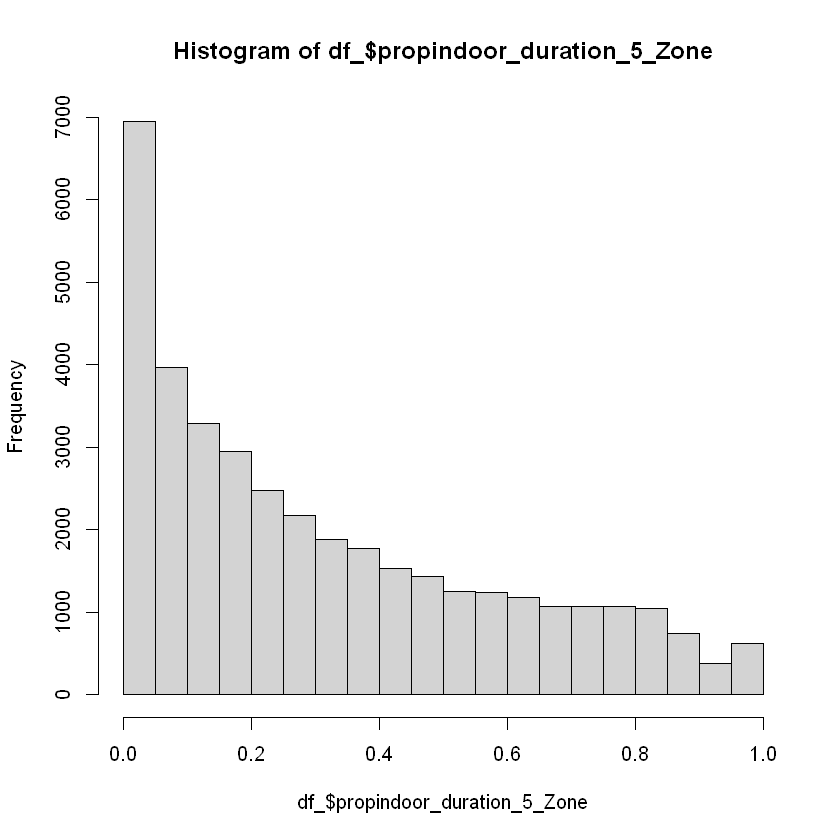

In [87]:
hist(df_$propindoor_duration_5_Zone)

 Family: beta  ( logit )
Formula:          
propindoor_duration_5_Zone ~ CLASS + Treatment * ns(time, 2) +  
    scale(KBF_interp) + scale(weight_interp) + (1 | PenID/HenID)
Data: df_

     AIC      BIC   logLik deviance df.resid 
-55215.7 -55104.6  27620.9 -55241.7    38067 

Random effects:

Conditional model:
 Groups      Name        Variance Std.Dev.
 HenID:PenID (Intercept) 1.17618  1.08452 
 PenID       (Intercept) 0.00585  0.07648 
Number of obs: 38080, groups:  HenID:PenID, 210; PenID, 8

Dispersion parameter for beta family (): 4.21 

Conditional model:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -0.852237   0.128740  -6.620 3.60e-11 ***
CLASSLEXP                  0.044780   0.219476   0.204 0.838327    
CLASSMEXP                 -0.281026   0.198785  -1.414 0.157444    
TreatmentOFH               0.543246   0.162116   3.351 0.000805 ***
ns(time, 2)1              -0.358022   0.087477  -4.093 4.26e-05 ***
ns(time, 2)2           

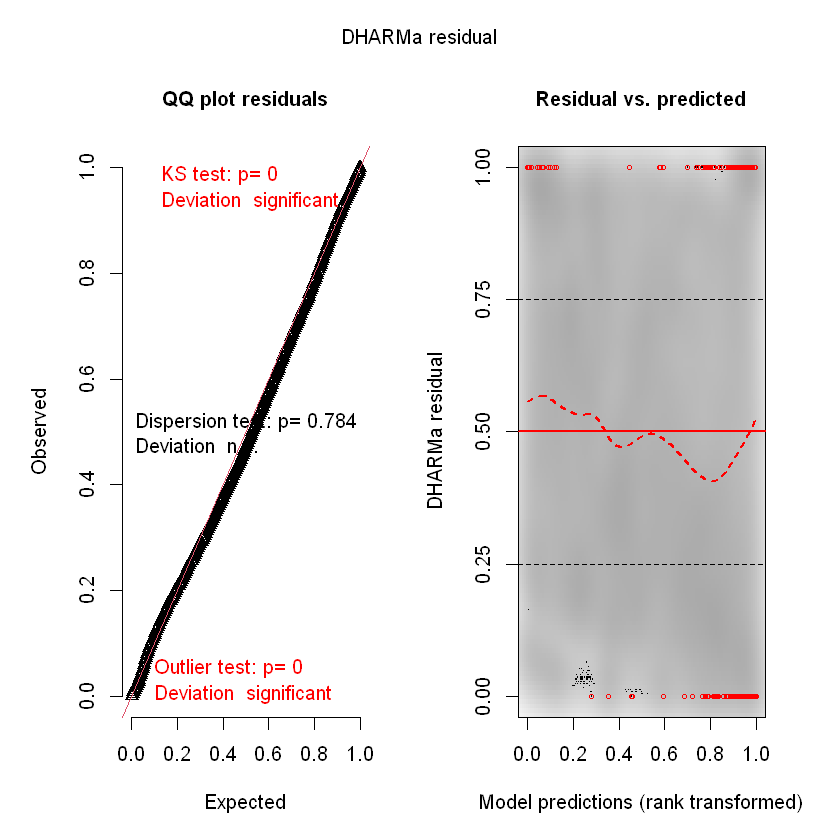


	DHARMa nonparametric dispersion test via sd of residuals fitted vs.
	simulated

data:  simulationOutput
dispersion = 1.0139, p-value = 0.784
alternative hypothesis: two.sided


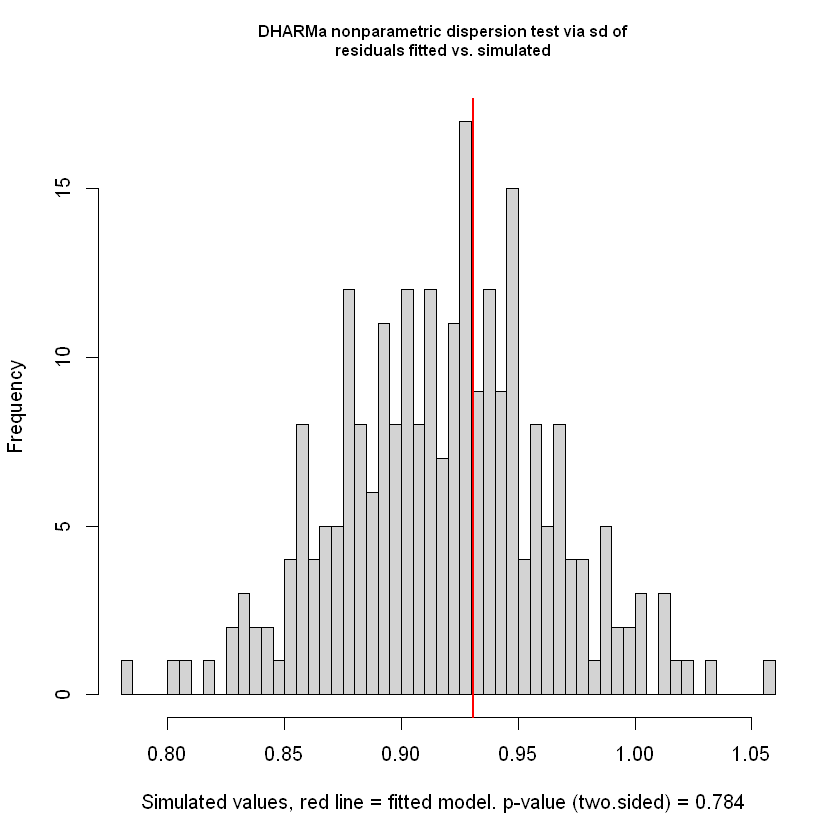

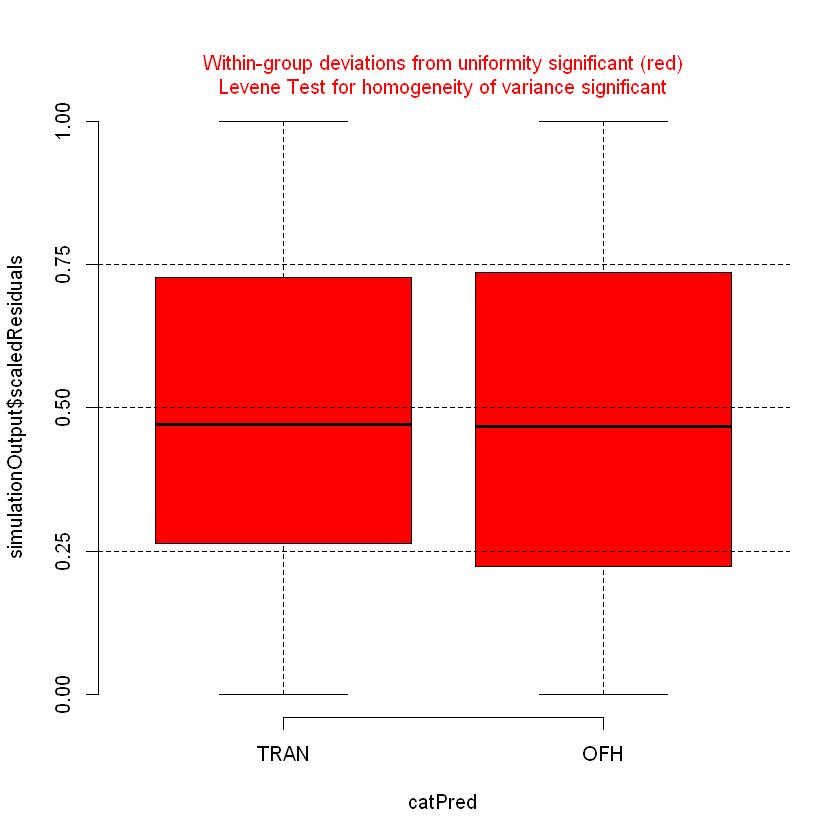

In [88]:
#ns(time, 2)
fit5 = glmmTMB(propindoor_duration_5_Zone ~  CLASS + Treatment * ns(time, 2) + scale(KBF_interp) + scale(weight_interp) + (1|PenID/HenID), 
           data=df_, family=beta_family(link="logit"))
summary(fit5)
simulationOutput = simulateResiduals(fittedModel=fit5)
plot(simulationOutput, quantreg = T)
testDispersion(simulationOutput)
plotResiduals(simulationOutput, form = df_$Treatment)

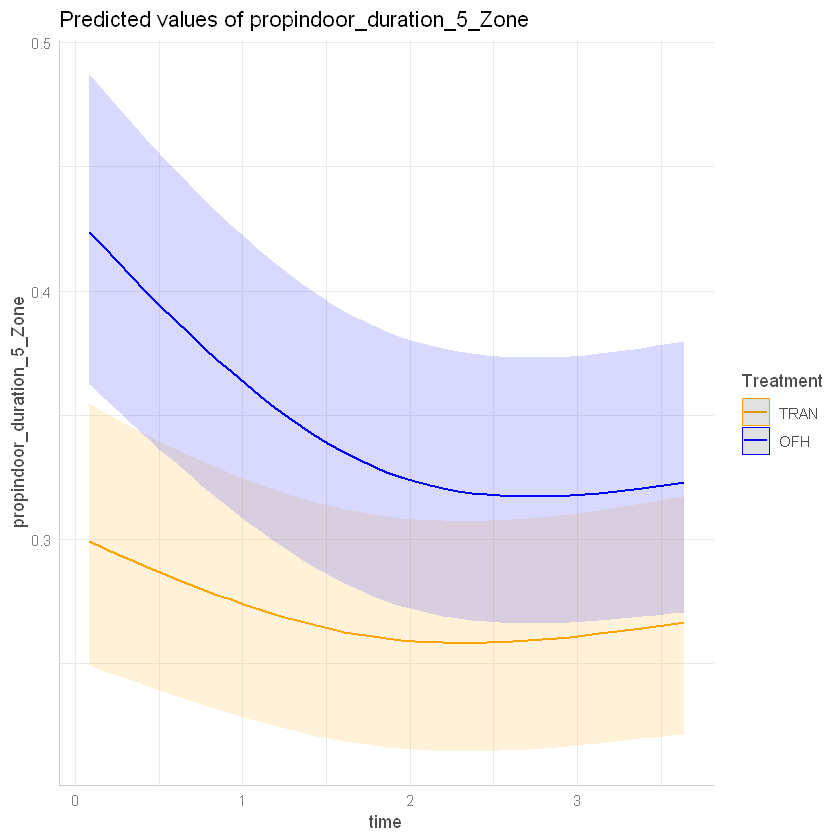

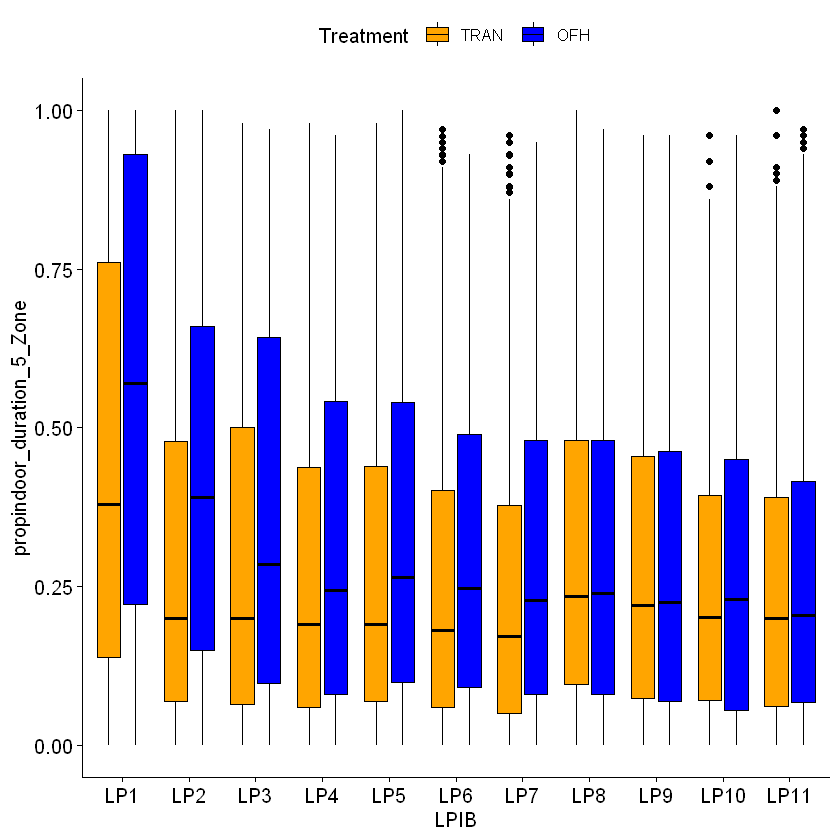

In [89]:
me = ggpredict(fit5, terms = c('time [all]','Treatment'), type = "fixed", ci.lvl = 0.95)
plot(me, color=c('orange','blue')) ##, add.data=TRUE
ggboxplot(data=df_,x='LPIB',y='propindoor_duration_5_Zone', fill='Treatment')+scale_fill_manual(values=c('orange', 'blue'))

# mid_cum_Z4_h_Morning

In [160]:
set.seed(0)
dim(df)
df_ = df[, c('HenID','PenID','time','CLASS','KBF_interp','weight_interp','Treatment','time2','DIB', 'LPIB',
            'mid_cum_Z4_h_Morning')]
df_ = df_[df$'LPIB'!='LP1', ] #not uppose to lay egg! and hard to fit wiht this
df_ = na.omit(df_)
dim(df_)
df_= df_ %>% group_by(DIB, Treatment) %>% slice_sample(n = ndibtreatsample)
#df_ = df_[sample(nrow(df_), 5000), ]
#remove rows from data frame with NA values in column 'b'
dim(df_)

[1] 38932    26

[1] 34827    11

[1] 34827    11

In [161]:
#WMWM: with ndibtreatsample: 

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
mid_cum_Z4_h_Morning ~ CLASS + Treatment * ns(time, 2) + scale(KBF_interp) +  
    scale(weight_interp) + (1 | PenID/HenID)
   Data: df_

REML criterion at convergence: 82350.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-6.1431 -0.5843 -0.0934  0.4770  5.5536 

Random effects:
 Groups      Name        Variance Std.Dev.
 HenID:PenID (Intercept) 0.488560 0.69897 
 PenID       (Intercept) 0.003195 0.05652 
 Residual                0.604672 0.77761 
Number of obs: 34827, groups:  HenID:PenID, 210; PenID, 8

Fixed effects:
                            Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)                4.401e+00  8.502e-02  1.022e+01  51.767 1.04e-13 ***
CLASSLEXP                  1.681e-02  1.413e-01  1.942e+02   0.119  0.90539    
CLASSMEXP                  1.344e-01  1.282e-01  1.925e+02   1.049  0.29564    
TreatmentOFH              -2.151e-01  1.07

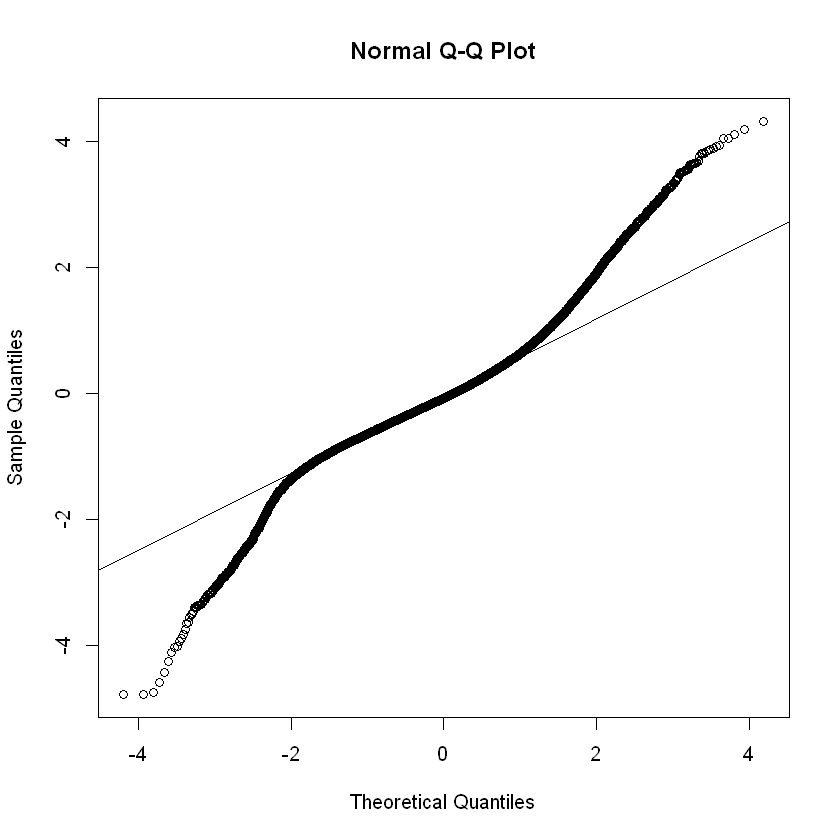

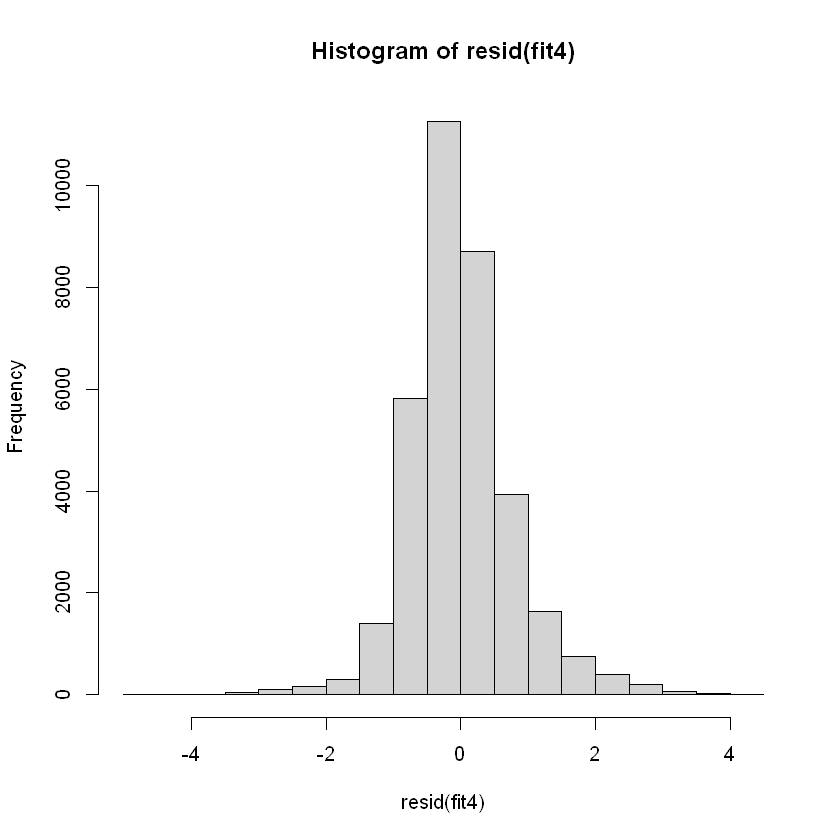

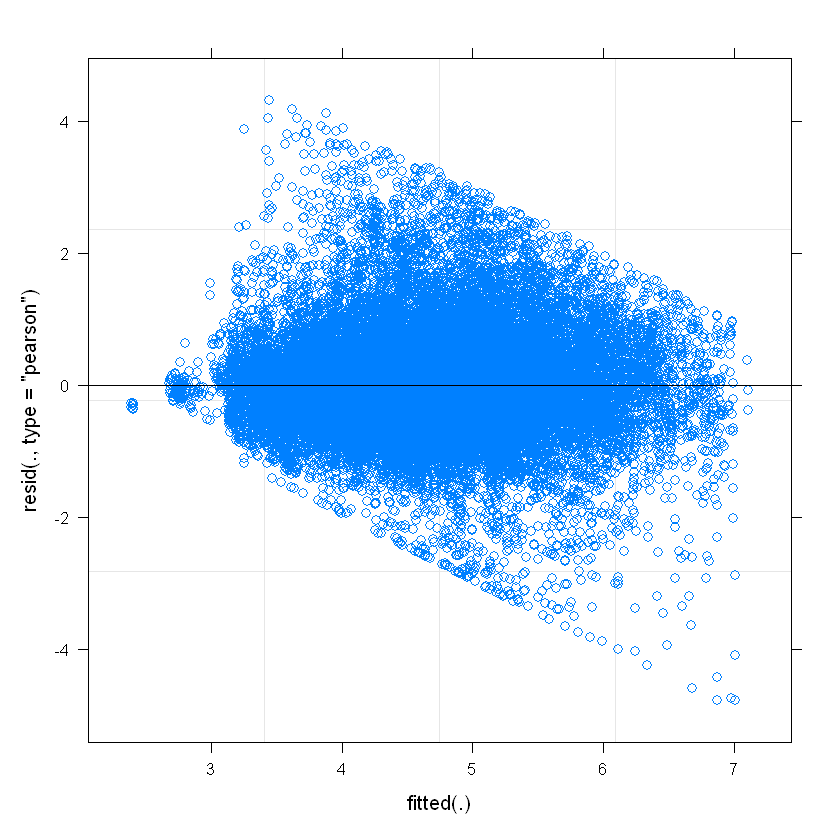

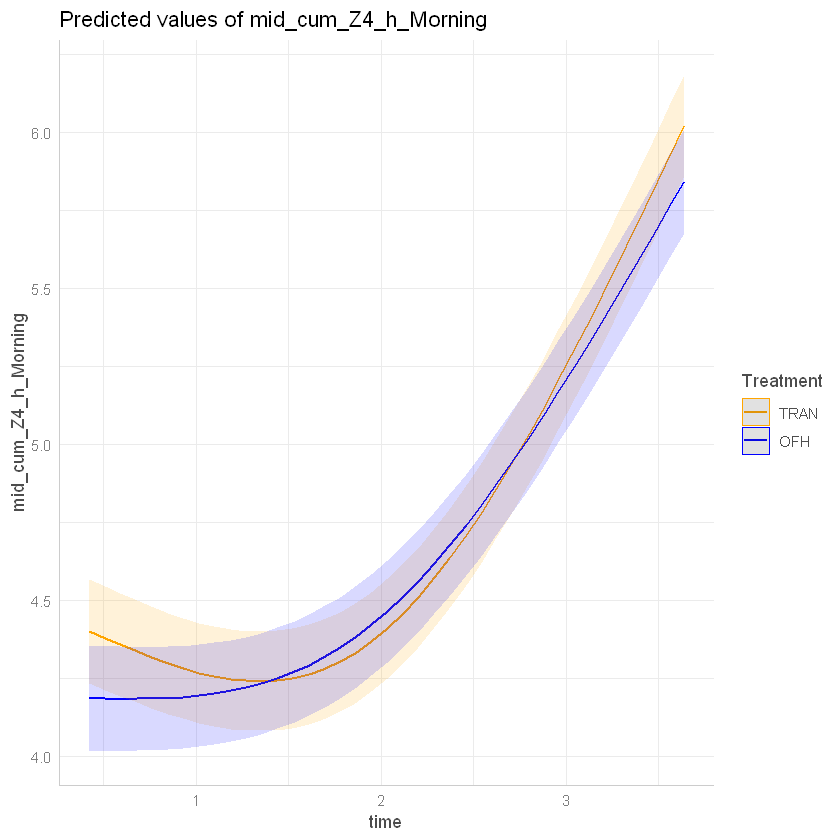

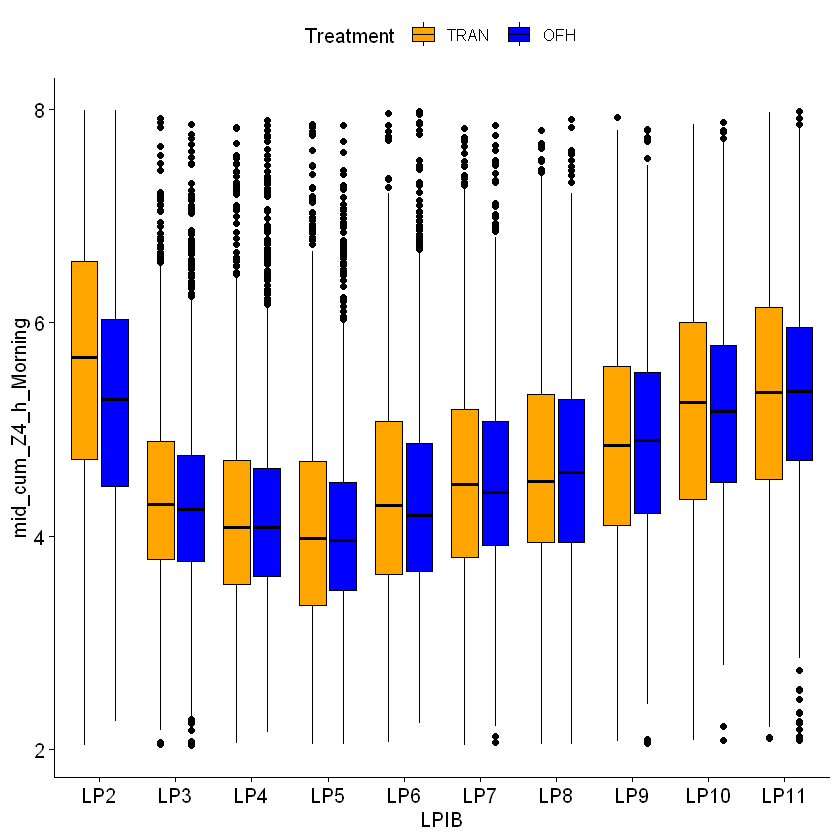

In [165]:
fit4 = lmer(mid_cum_Z4_h_Morning ~ CLASS + Treatment * ns(time, 2) + scale(KBF_interp) + scale(weight_interp) + (1|PenID/HenID), 
       data=df_)
summary(fit4)
#VIF>5:
#scale(COVARIATE_MEAN_CHELSA_BIO_Temperature_Mean_Minus_Min)+scale(COVARIATE_MEAN_SG_Soil_pH_H2O_000cm_to_005cm_mean)+
######normally distributed residuals
qqnorm(resid(fit4))
qqline(resid(fit4))
hist(resid(fit4))
######check homogeneity of variance (residuals has constant variance)
plot(fit4)
#not enough pvariance penid in ranom effect: removed it. also in fixed effects: not significant
me = ggpredict(fit4, terms = c('time [all]','Treatment'), type = "fixed", ci.lvl = 0.95)
plot(me, color=c('orange','blue')) ##, add.data=TRUE
ggboxplot(data=df_,x='LPIB',y='mid_cum_Z4_h_Morning', fill='Treatment')+scale_fill_manual(values=c('orange', 'blue'))

 Family: Gamma  ( log )
Formula:          
mid_cum_Z4_h_Morning ~ CLASS + Treatment * ns(time, 2) + scale(KBF_interp) +  
    scale(weight_interp) + (1 | PenID/HenID)
Data: df_

     AIC      BIC   logLik deviance df.resid 
 80383.6  80493.6 -40178.8  80357.6    34814 

Random effects:

Conditional model:
 Groups      Name        Variance  Std.Dev. 
 HenID:PenID (Intercept) 2.386e-02 0.1544798
 PenID       (Intercept) 5.306e-08 0.0002304
Number of obs: 34827, groups:  HenID:PenID, 210; PenID, 8

Dispersion estimate for Gamma family (sigma^2): 0.0277 

Conditional model:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                1.463302   0.017665   82.84  < 2e-16 ***
CLASSLEXP                  0.009749   0.031196    0.31    0.755    
CLASSMEXP                  0.033999   0.028322    1.20    0.230    
TreatmentOFH              -0.038673   0.021946   -1.76    0.078 .  
ns(time, 2)1               0.140204   0.013475   10.40  < 2e-16 ***
ns(time, 2)2   

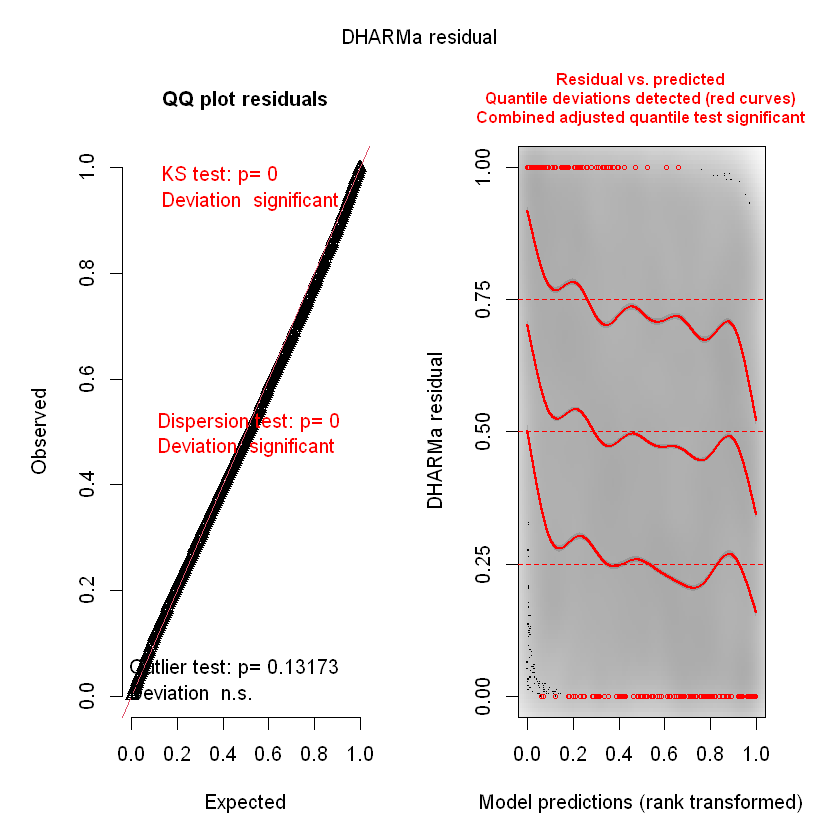

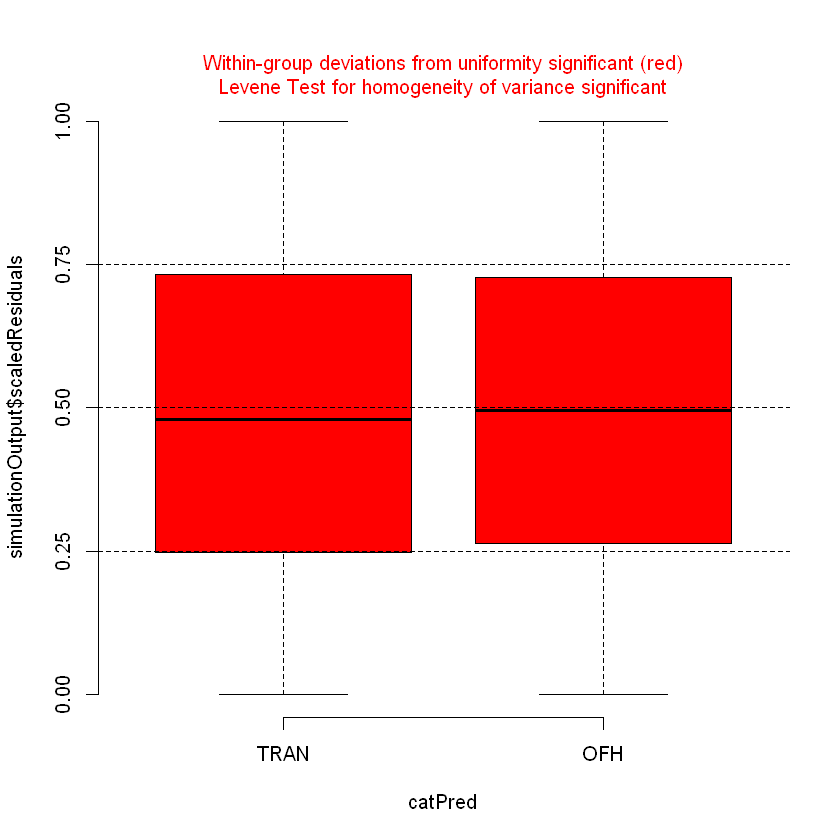

In [163]:
fit4 = glmmTMB(mid_cum_Z4_h_Morning ~  CLASS + Treatment * ns(time, 2) + scale(KBF_interp) + scale(weight_interp) + (1|PenID/HenID), 
               family = Gamma(link = "log"), data=df_)
summary(fit4)
simulationOutput = simulateResiduals(fit4)
plot(simulationOutput, quantreg = T)
plotResiduals(simulationOutput, form = df_$Treatment)

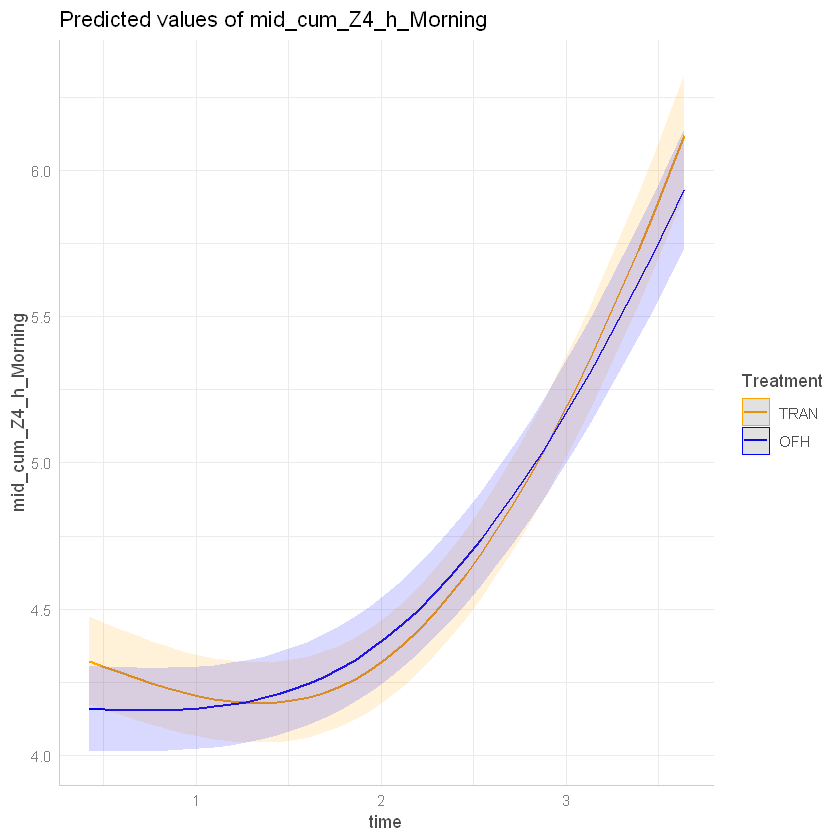

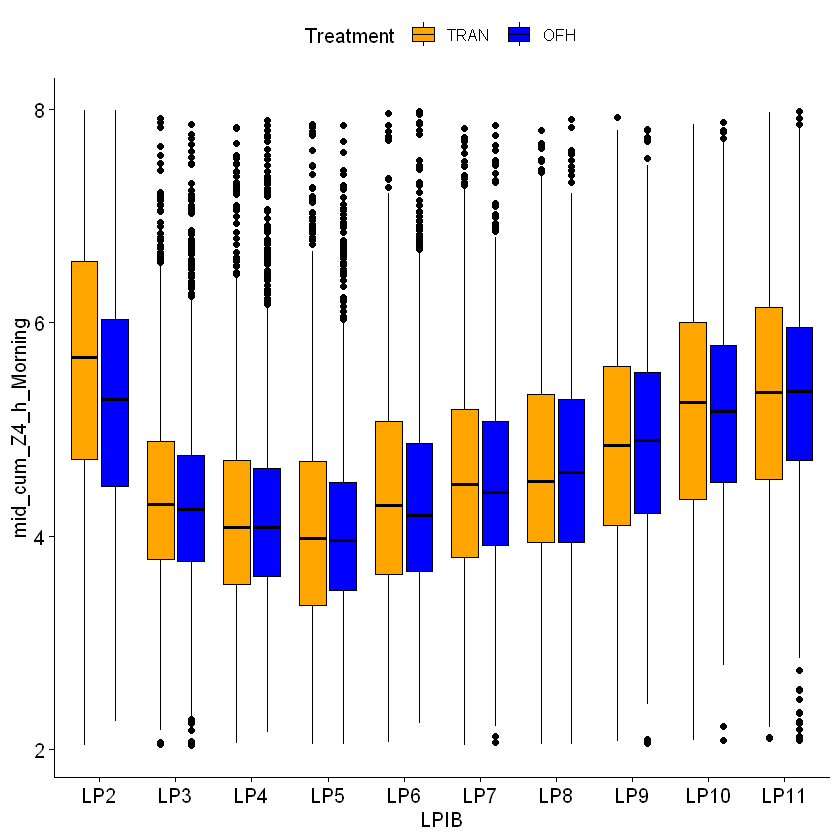

In [164]:
me = ggpredict(fit4, terms = c('time [all]','Treatment'), type = "fixed", ci.lvl = 0.95)
plot(me, color=c('orange','blue')) ##, add.data=TRUE
ggboxplot(data=df_,x='LPIB',y='mid_cum_Z4_h_Morning', fill='Treatment')+scale_fill_manual(values=c('orange', 'blue'))

In [ ]:
#with n=10
#Maybe: 100 time with 10, and say its significant if 95% of time sgnificant?.  but output estimates and all, even plot
#from teh full model, PLUS adding the meand p-value, with mean CI form the 100 models?

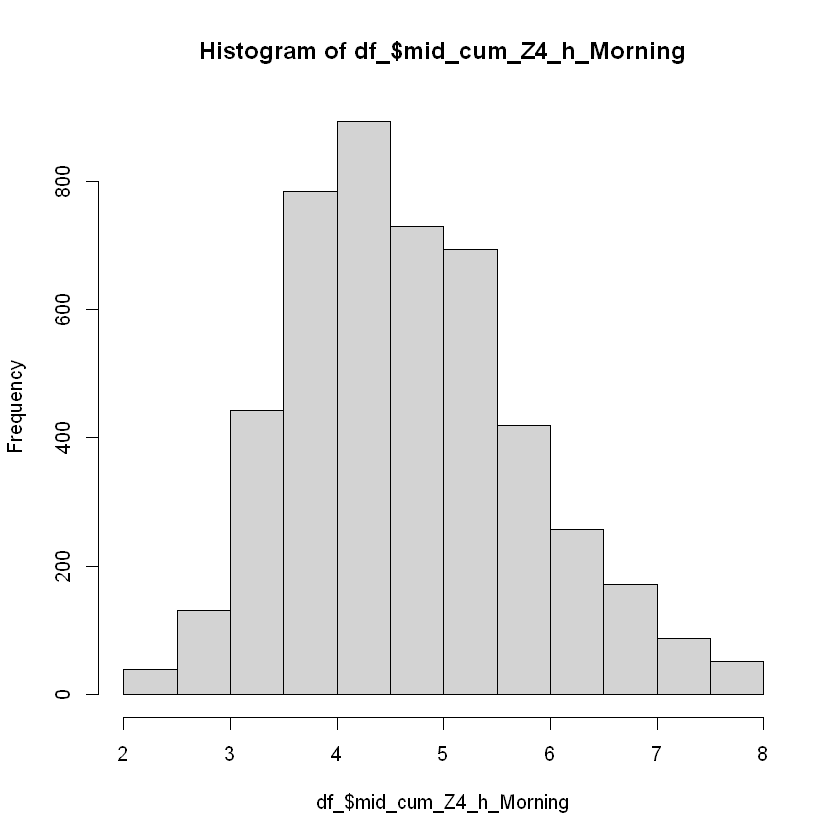

In [156]:
hist(df_$mid_cum_Z4_h_Morning)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: sqrt(mid_cum_Z4_h_Morning) ~ CLASS + Treatment * ns(time, 2) +  
    scale(KBF_interp) + scale(weight_interp) + (1 | PenID/HenID)
   Data: df_

REML criterion at convergence: -2260.3

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.9047 -0.5993 -0.0595  0.5028  4.4518 

Random effects:
 Groups      Name        Variance  Std.Dev.
 HenID:PenID (Intercept) 0.0244210 0.1563  
 PenID       (Intercept) 0.0006654 0.0258  
 Residual                0.0316149 0.1778  
Number of obs: 4700, groups:  HenID:PenID, 209; PenID, 8

Fixed effects:
                            Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)                2.123e+00  2.694e-02  1.767e+01  78.788   <2e-16 ***
CLASSLEXP                 -8.865e-04  3.239e-02  1.679e+02  -0.027   0.9782    
CLASSMEXP                  1.960e-02  2.946e-02  1.685e+02   0.665   0.5068    
TreatmentOFH              -4.061e-

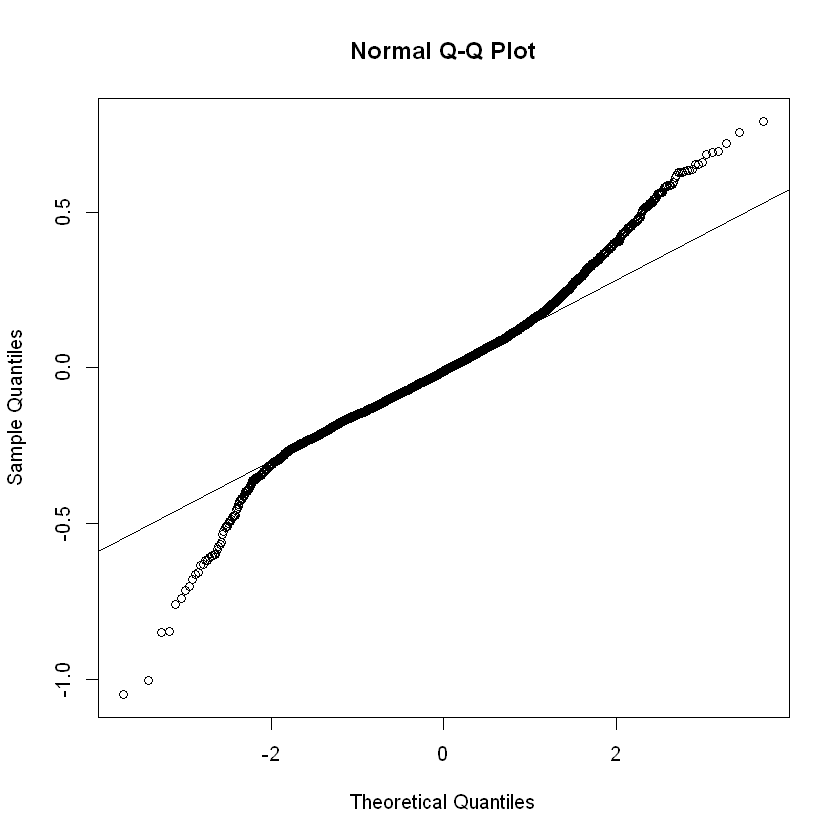

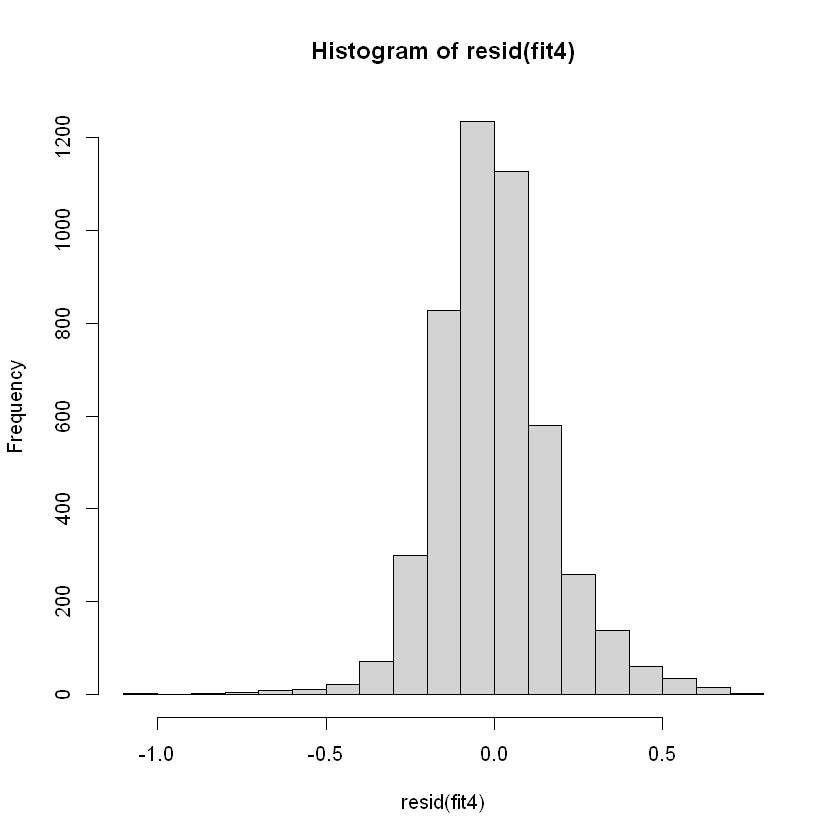

Model has sqrt-transformed response. Back-transforming predictions to original response scale. Standard errors are still on the sqrt-scale.



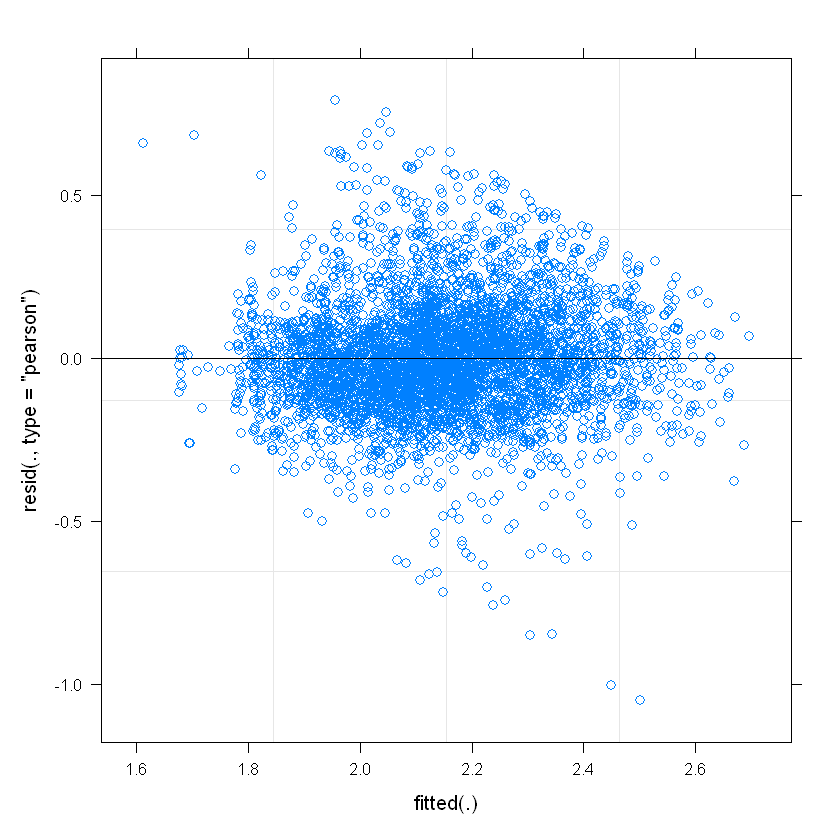

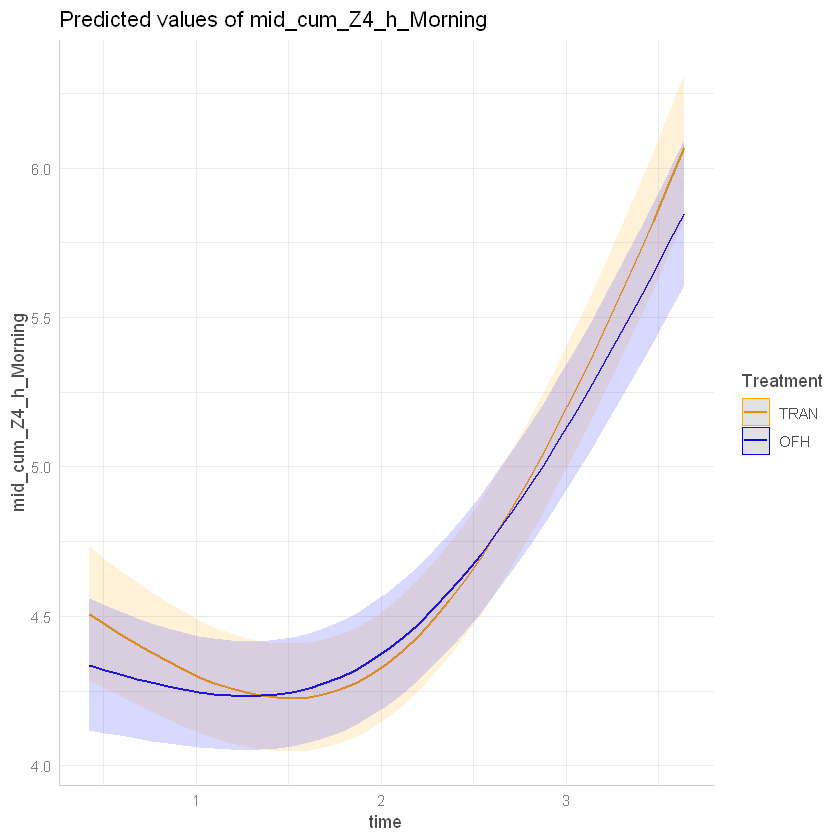

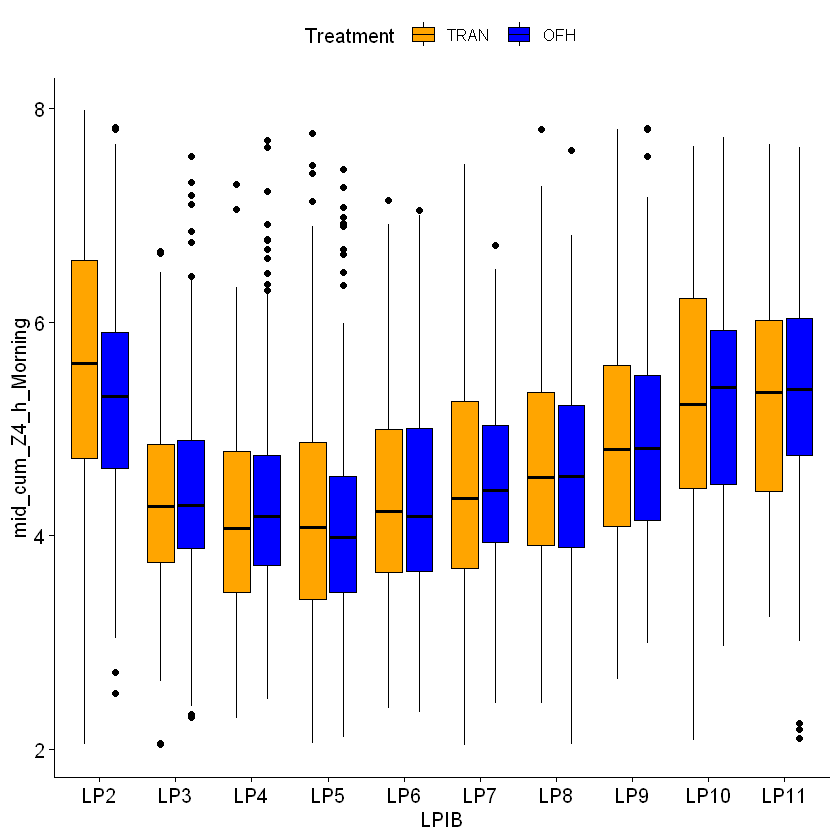

In [157]:
fit4 = lmer(sqrt(mid_cum_Z4_h_Morning) ~ CLASS + Treatment * ns(time, 2) + scale(KBF_interp) + scale(weight_interp) + (1|PenID/HenID), 
       data=df_)
summary(fit4)
######normally distributed residuals
qqnorm(resid(fit4))
qqline(resid(fit4))
hist(resid(fit4))
######check homogeneity of variance (residuals has constant variance)
plot(fit4)
#not enough pvariance penid in ranom effect: removed it. also in fixed effects: not significant
me = ggpredict(fit4, terms = c('time [all]','Treatment'), type = "fixed", ci.lvl = 0.95)
plot(me, color=c('orange','blue')) ##, add.data=TRUE
ggboxplot(data=df_,x='LPIB',y='mid_cum_Z4_h_Morning', fill='Treatment')+scale_fill_manual(values=c('orange', 'blue'))

 Family: Gamma  ( log )
Formula:          
mid_cum_Z4_h_Morning ~ CLASS + Treatment * ns(time, 2) + scale(KBF_interp) +  
    scale(weight_interp) + (1 | PenID/HenID)
Data: df_

     AIC      BIC   logLik deviance df.resid 
 11328.1  11412.0  -5651.0  11302.1     4687 

Random effects:

Conditional model:
 Groups      Name        Variance  Std.Dev.
 HenID:PenID (Intercept) 0.0208860 0.14452 
 PenID       (Intercept) 0.0002289 0.01513 
Number of obs: 4700, groups:  HenID:PenID, 209; PenID, 8

Dispersion estimate for Gamma family (sigma^2): 0.0275 

Conditional model:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                1.502467   0.023362   64.31   <2e-16 ***
CLASSLEXP                  0.002576   0.030044    0.09   0.9317    
CLASSMEXP                  0.021649   0.027263    0.79   0.4271    
TreatmentOFH              -0.034197   0.026390   -1.30   0.1950    
ns(time, 2)1               0.068025   0.035263    1.93   0.0537 .  
ns(time, 2)2       

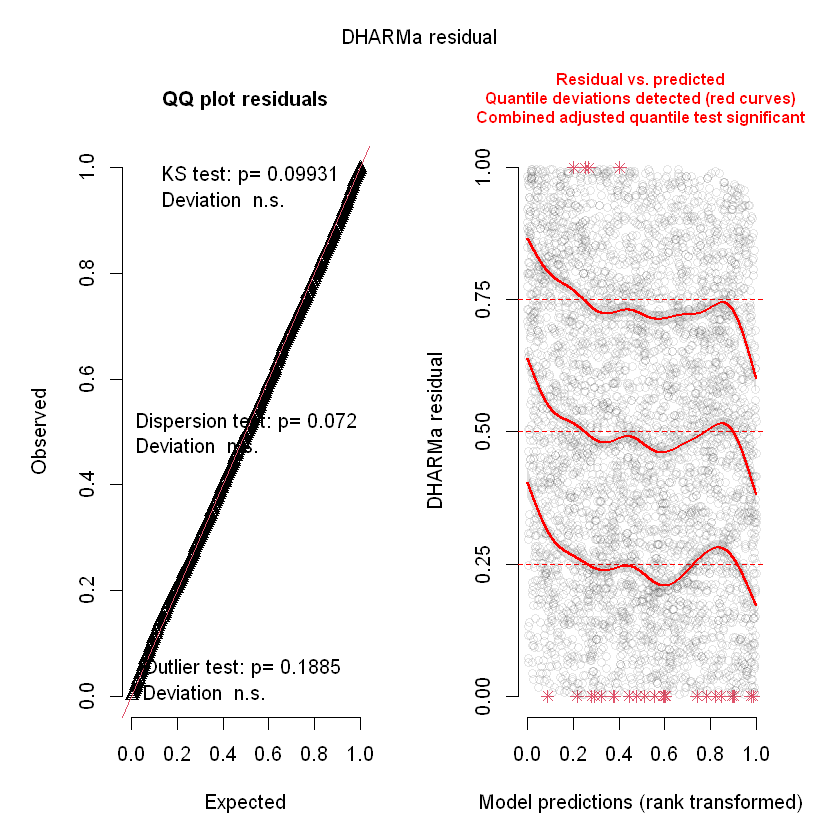

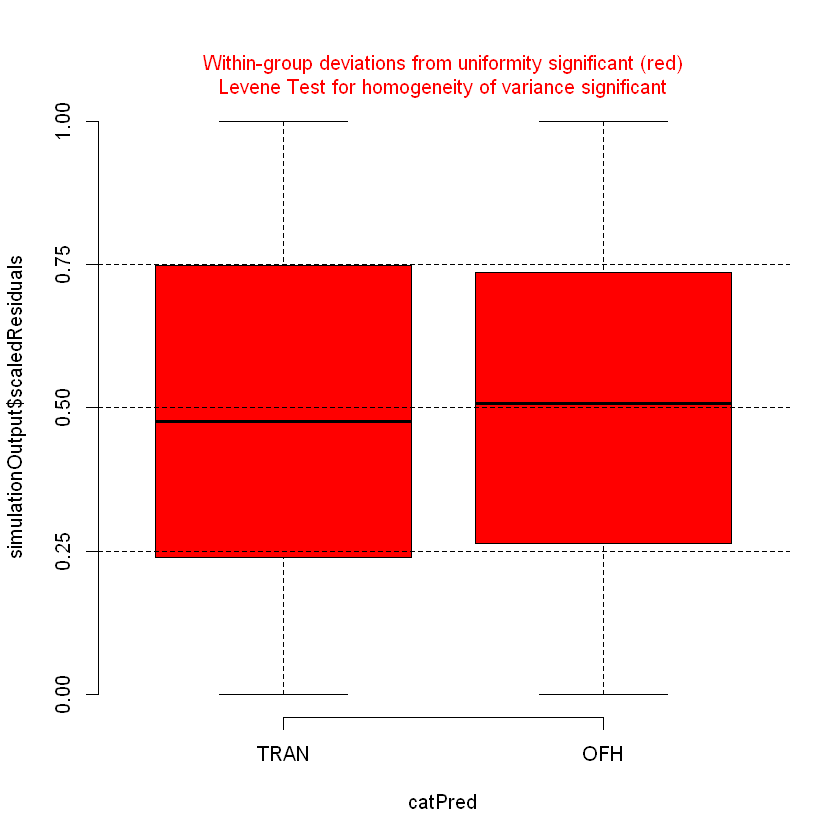

In [158]:
fit4 = glmmTMB(mid_cum_Z4_h_Morning ~  CLASS + Treatment * ns(time, 2) + scale(KBF_interp) + scale(weight_interp) + (1|PenID/HenID), 
               family = Gamma(link = "log"), data=df_)
summary(fit4)
simulationOutput = simulateResiduals(fit4)
plot(simulationOutput, quantreg = T)
plotResiduals(simulationOutput, form = df_$Treatment)

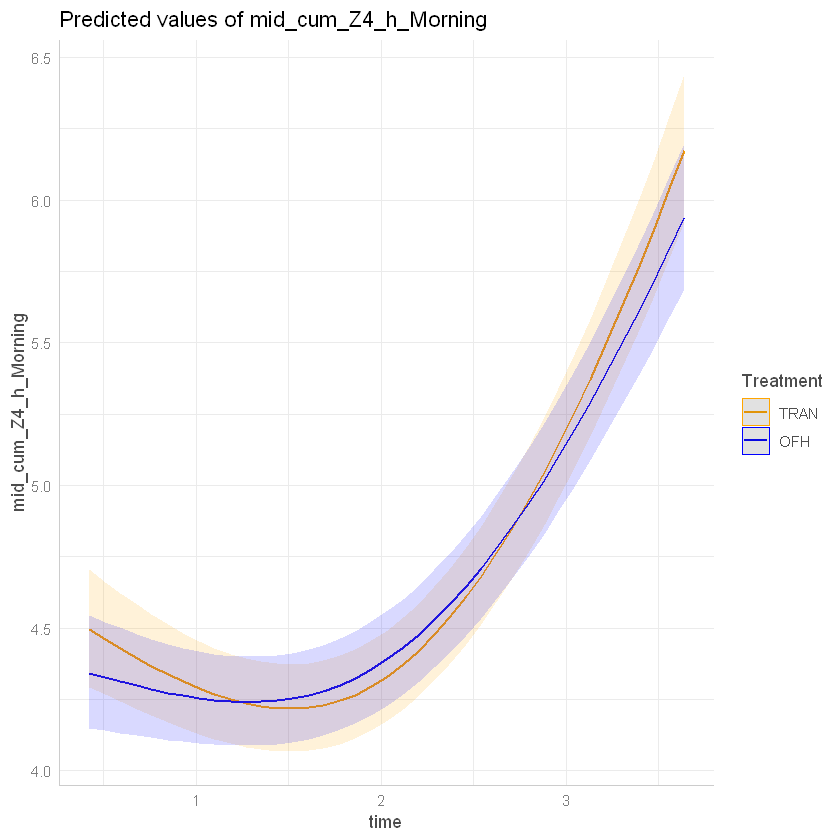

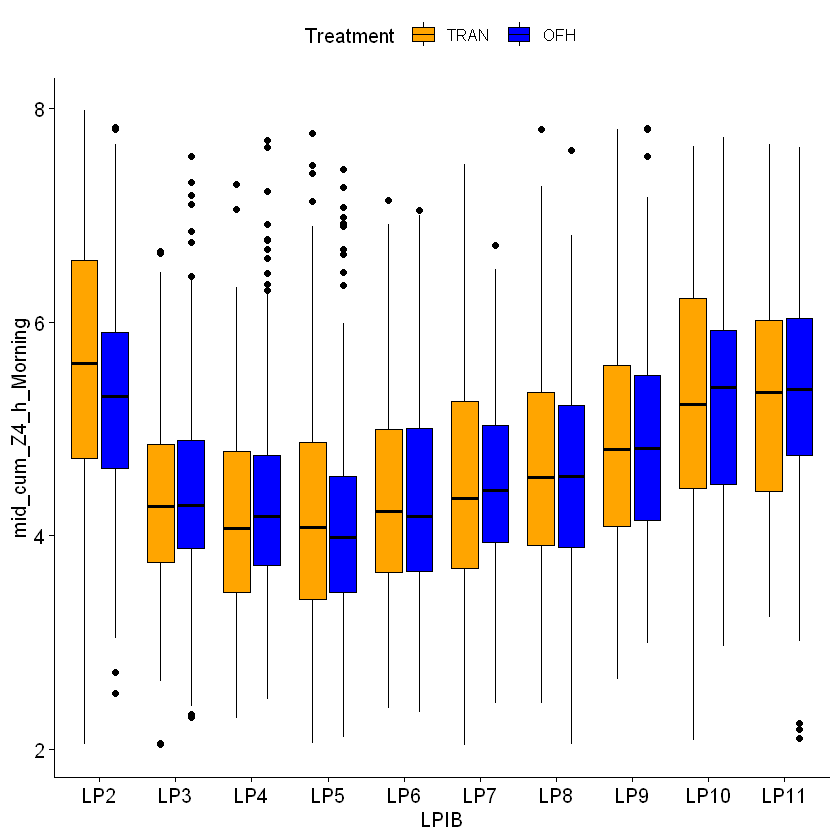

In [159]:
me = ggpredict(fit4, terms = c('time [all]','Treatment'), type = "fixed", ci.lvl = 0.95)
plot(me, color=c('orange','blue')) ##, add.data=TRUE
ggboxplot(data=df_,x='LPIB',y='mid_cum_Z4_h_Morning', fill='Treatment')+scale_fill_manual(values=c('orange', 'blue'))

# vertical_travel_distance_fulllight_perinsideh

In [94]:
set.seed(0)
dim(df)
df_ = df[, c('HenID','PenID','time','CLASS','KBF_interp','weight_interp','Treatment','time2','DIB', 'LPIB',
            'vertical_travel_distance_perinsideh')]
df_ = na.omit(df_)
dim(df_)
df_= df_ %>% group_by(DIB, Treatment) %>% slice_sample(n = ndibtreatsample)
#df_ = df_[sample(nrow(df_), 5000), ]
#remove rows from data frame with NA values in column 'b'
dim(df_)

[1] 38932    26

[1] 38080    10

[1] 38080    10

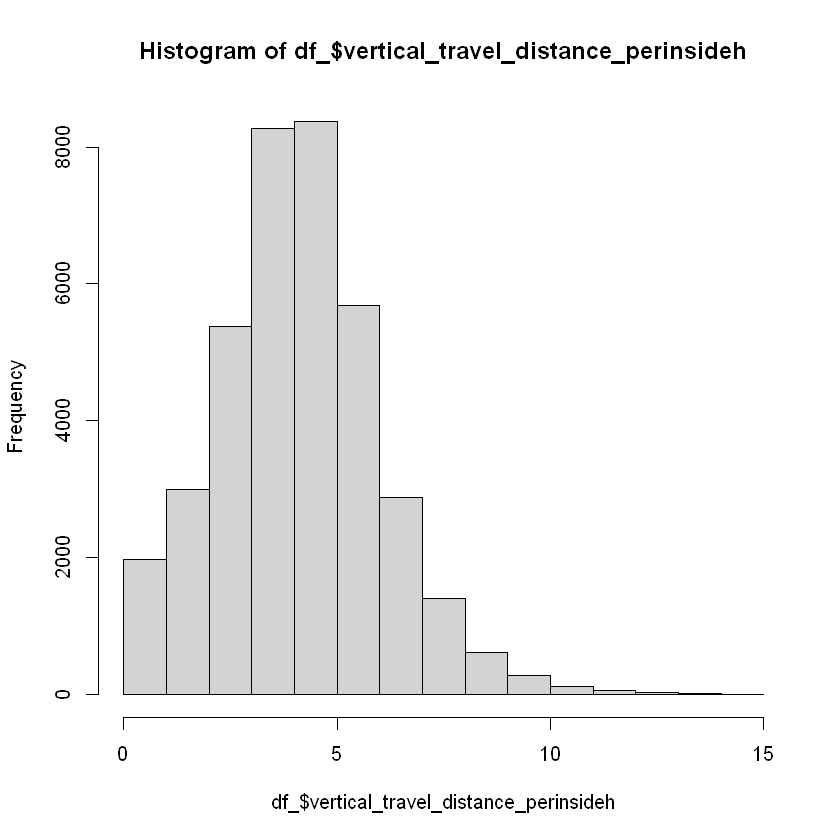

In [95]:
hist(df_$vertical_travel_distance_perinsideh)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: vertical_travel_distance_perinsideh ~ CLASS + Treatment * ns(time,  
    3) + scale(KBF_interp) + scale(weight_interp) + (1 | HenID)
   Data: df_

REML criterion at convergence: 124541.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-5.3814 -0.5732 -0.0568  0.5001  8.1092 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 1.868    1.367   
 Residual             1.496    1.223   
Number of obs: 38080, groups:  HenID, 210

Fixed effects:
                            Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)                2.698e+00  1.637e-01  3.106e+02  16.483  < 2e-16 ***
CLASSLEXP                  2.815e-01  2.756e-01  2.049e+02   1.021 0.308257    
CLASSMEXP                  1.448e-01  2.502e-01  2.050e+02   0.579 0.563342    
TreatmentOFH              -7.701e-01  1.948e-01  2.295e+02  -3.953 0.000103 ***
ns(time, 3)1         

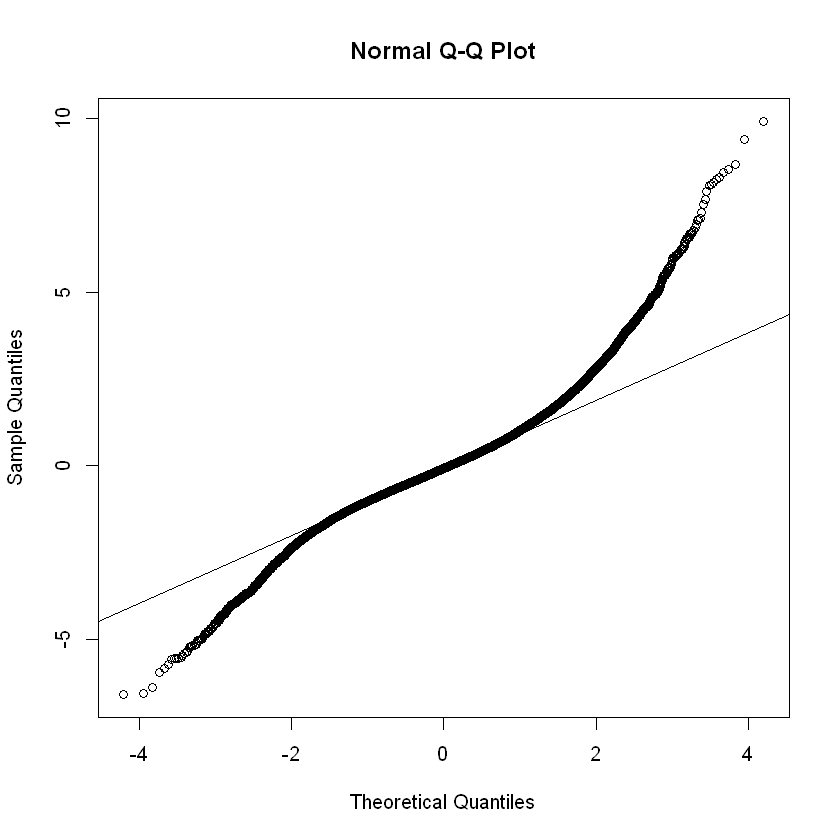

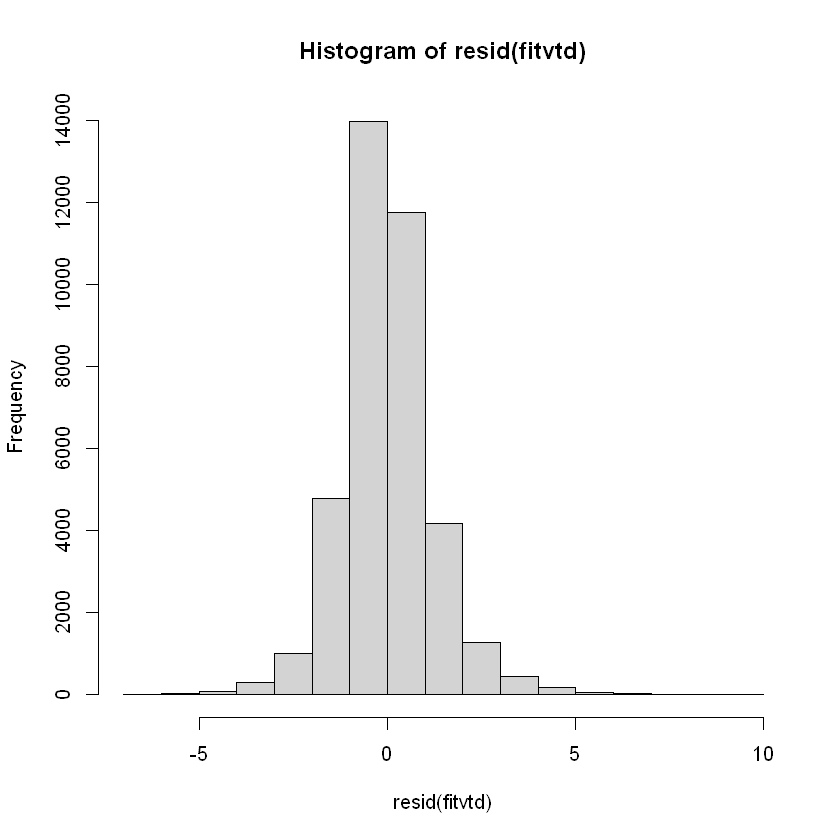

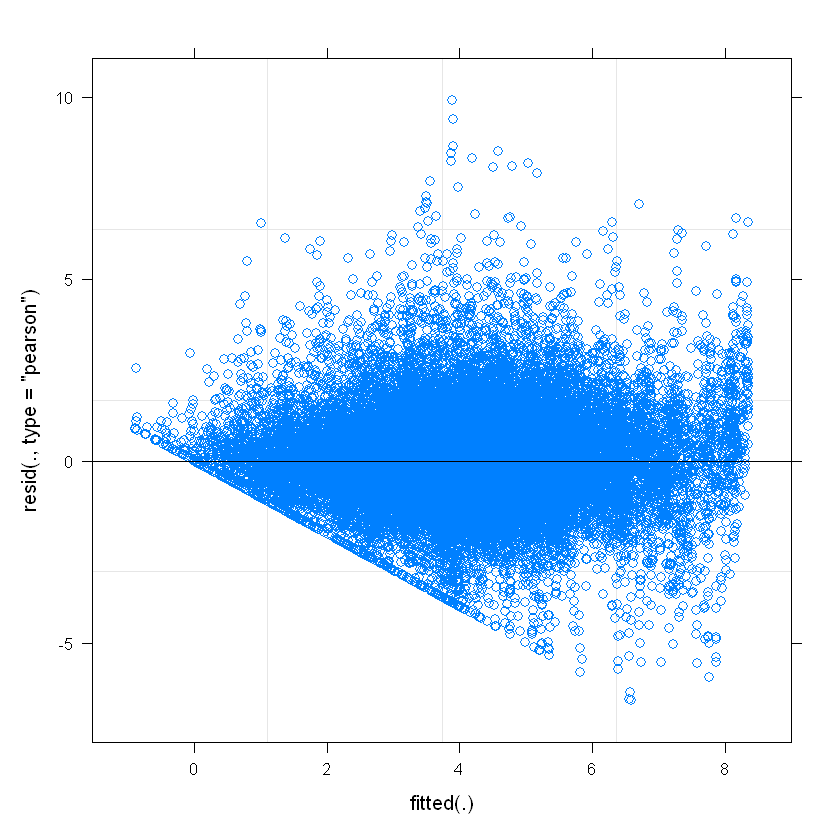

In [96]:
fitvtd = lmer(vertical_travel_distance_perinsideh ~ CLASS + Treatment * ns(time, 2) + scale(KBF_interp) + scale(weight_interp) + (1|HenID), 
       data=df_)
summary(fitvtd)
#VIF>5:
#scale(COVARIATE_MEAN_CHELSA_BIO_Temperature_Mean_Minus_Min)+scale(COVARIATE_MEAN_SG_Soil_pH_H2O_000cm_to_005cm_mean)+
###### normally distributed residuals
qqnorm(resid(fitvtd))
qqline(resid(fitvtd))
hist(resid(fitvtd))
######check homogeneity of variance (residuals has constant variance)
plot(fitvtd)
#not enough pvariance penid in ranom effect: removed it. also in fixed effects: not significant

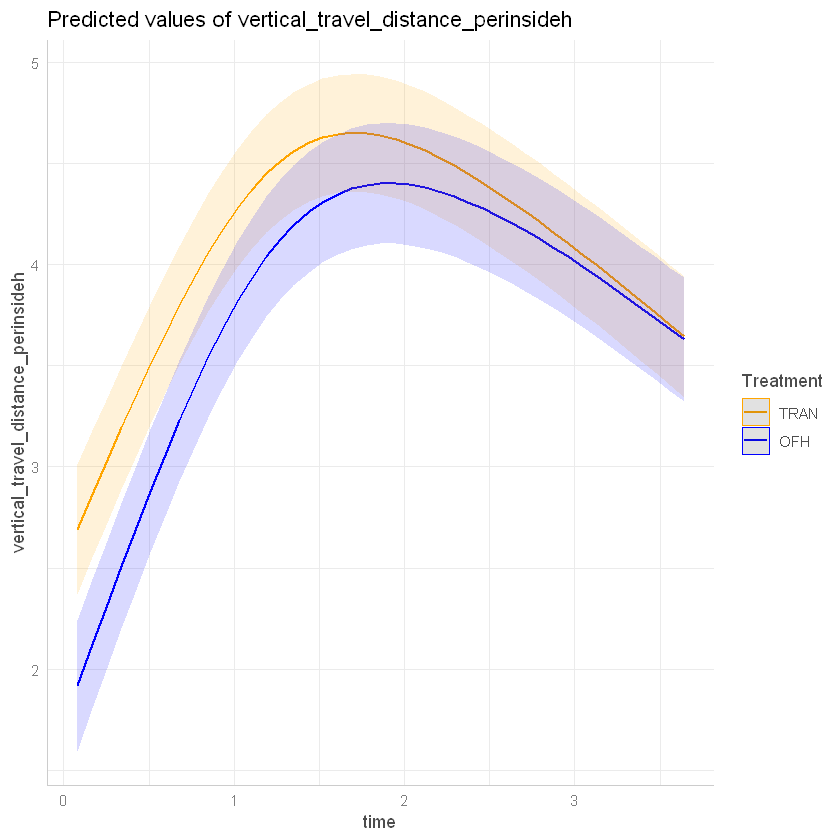

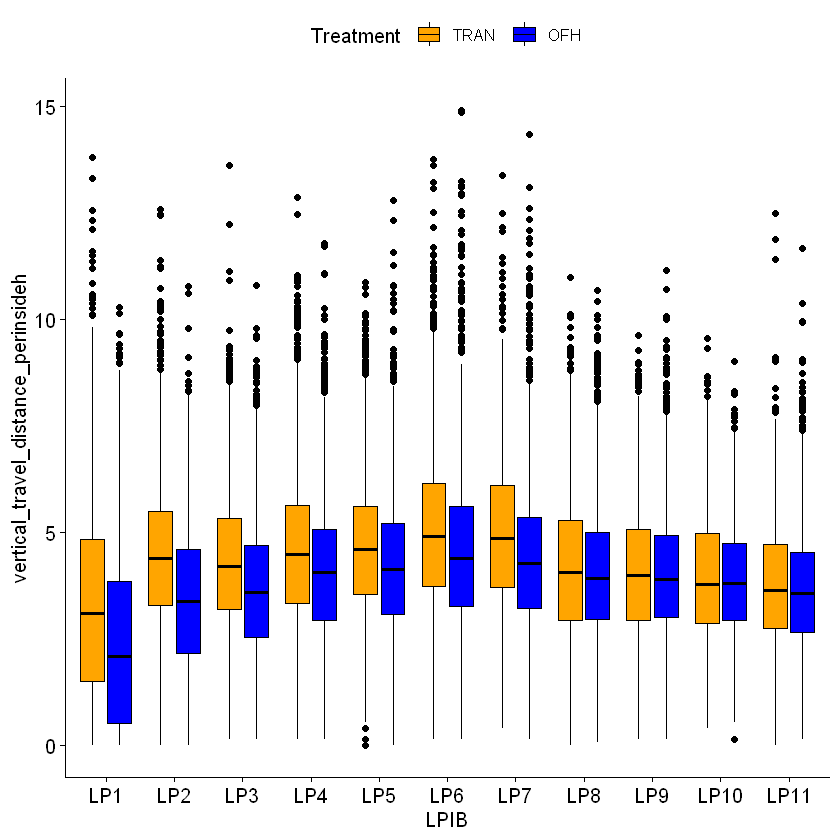

In [97]:
me = ggpredict(fitvtd, terms = c('time [all]','Treatment'), type = "fixed", ci.lvl = 0.95)
###, add.data=TRUE
plot(me, color=c('orange','blue'))
ggboxplot(data=df_,x='LPIB',y='vertical_travel_distance_perinsideh', fill='Treatment')+scale_fill_manual(values=c('orange', 'blue'))

## propindoor_duration_4_Zone

In [63]:
set.seed(0)
dim(df)
df_ = df[, c('HenID','PenID','time','CLASS','KBF_interp','weight_interp','Treatment','time2','DIB', 'LPIB',
            'propindoor_duration_4_Zone')]
df_ = na.omit(df_)
dim(df_)
df_= df_ %>% group_by(DIB, Treatment) %>% slice_sample(n = ndibtreatsample)
#df_ = df_[sample(nrow(df_), 5000), ]
#remove rows from data frame with NA values in column 'b'
dim(df_)

[1] 38932    26

[1] 38080    10

[1] 38080    10

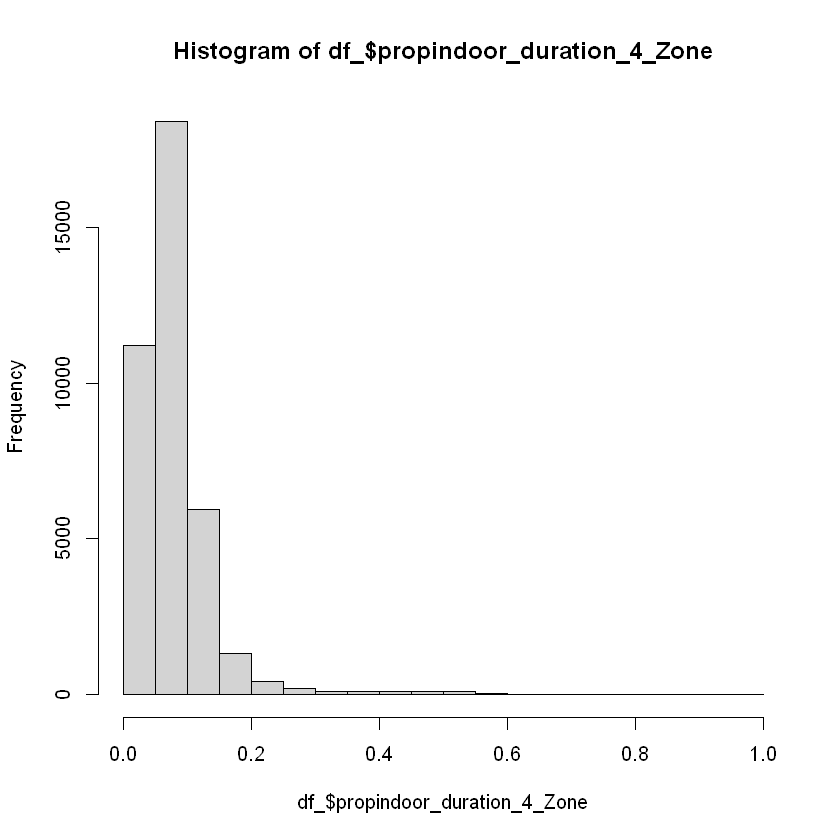

In [64]:
hist(df_$propindoor_duration_4_Zone)

 Family: Gamma  ( log )
Formula:          
propindoor_duration_4_Zone ~ CLASS + Treatment * time + scale(KBF_interp) +  
    scale(weight_interp) + (1 | PenID/HenID)
Data: df_

      AIC       BIC    logLik  deviance  df.resid 
-134975.1 -134881.1   67498.5 -134997.1     38069 

Random effects:

Conditional model:
 Groups      Name        Variance  Std.Dev. 
 HenID:PenID (Intercept) 1.556e-01 0.3944566
 PenID       (Intercept) 9.690e-08 0.0003113
Number of obs: 38080, groups:  HenID:PenID, 210; PenID, 8

Dispersion estimate for Gamma family (sigma^2): 0.416 

Conditional model:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -2.849107   0.045600  -62.48   <2e-16 ***
CLASSLEXP             0.048238   0.079913    0.60   0.5461    
CLASSMEXP             0.146079   0.072568    2.01   0.0441 *  
TreatmentOFH         -0.042524   0.056735   -0.75   0.4535    
time                  0.121087   0.008158   14.84   <2e-16 ***
scale(KBF_interp)    -0.007987   0.00

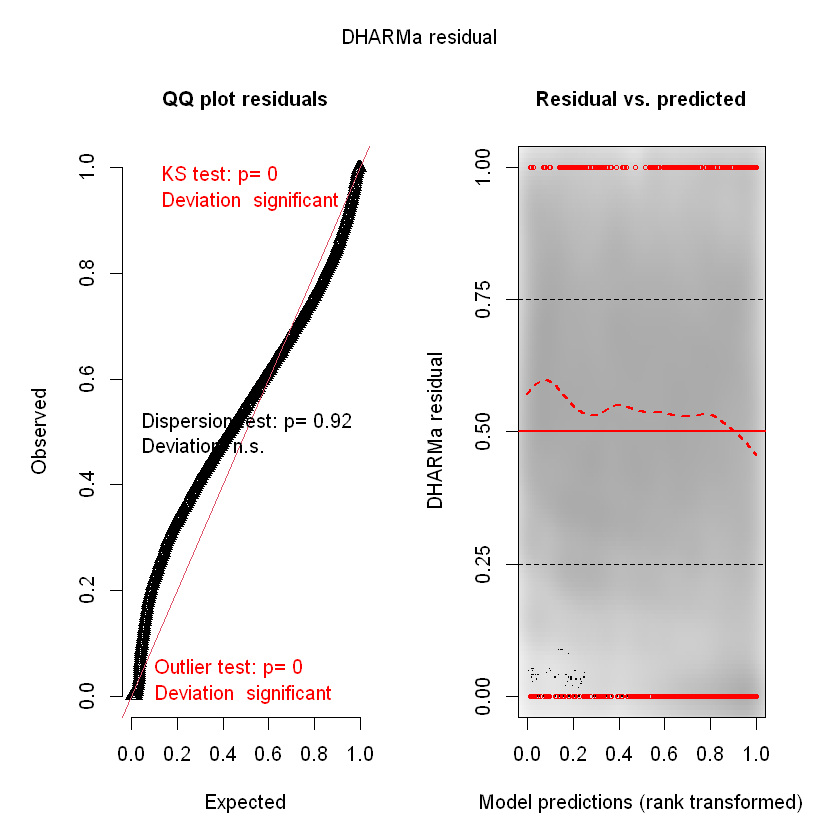

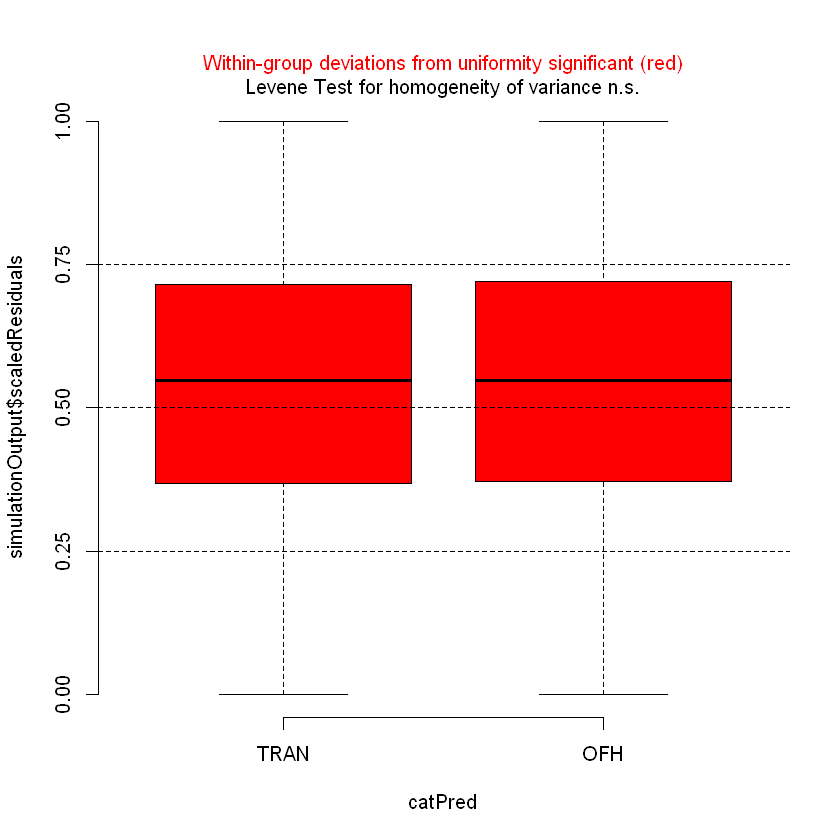

In [65]:
fit4 = glmmTMB(propindoor_duration_4_Zone ~  CLASS + Treatment * ns(time, 2) + scale(KBF_interp) + scale(weight_interp) + (1|PenID/HenID), 
               family = Gamma(link = "log"), data=df_)
summary(fit4)
simulationOutput = simulateResiduals(fit4)
plot(simulationOutput, quantreg = T)
plotResiduals(simulationOutput, form=df_$Treatment)

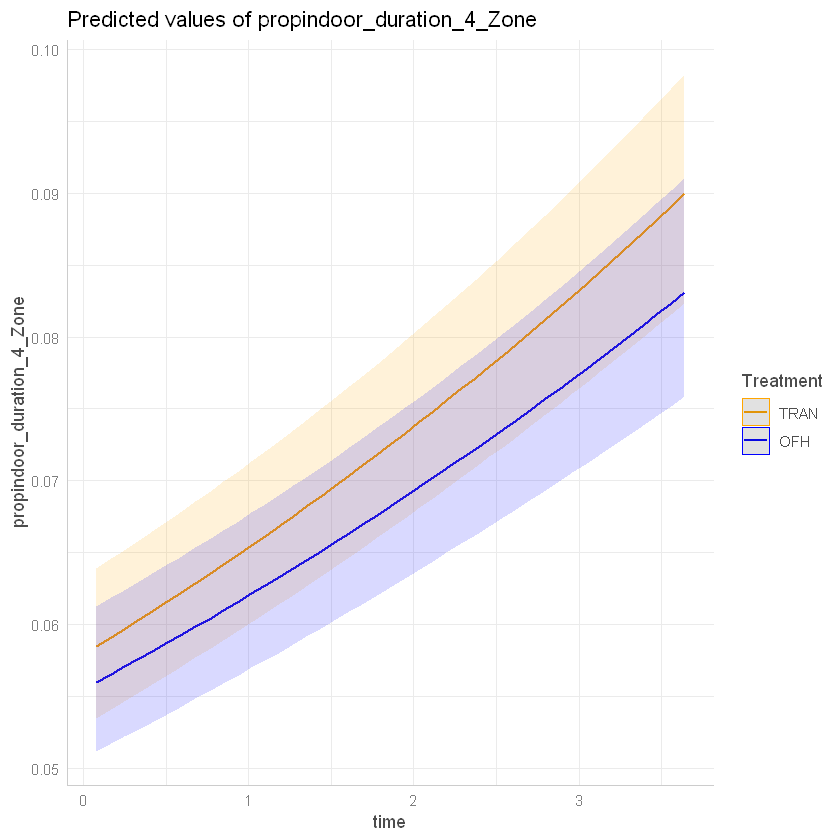

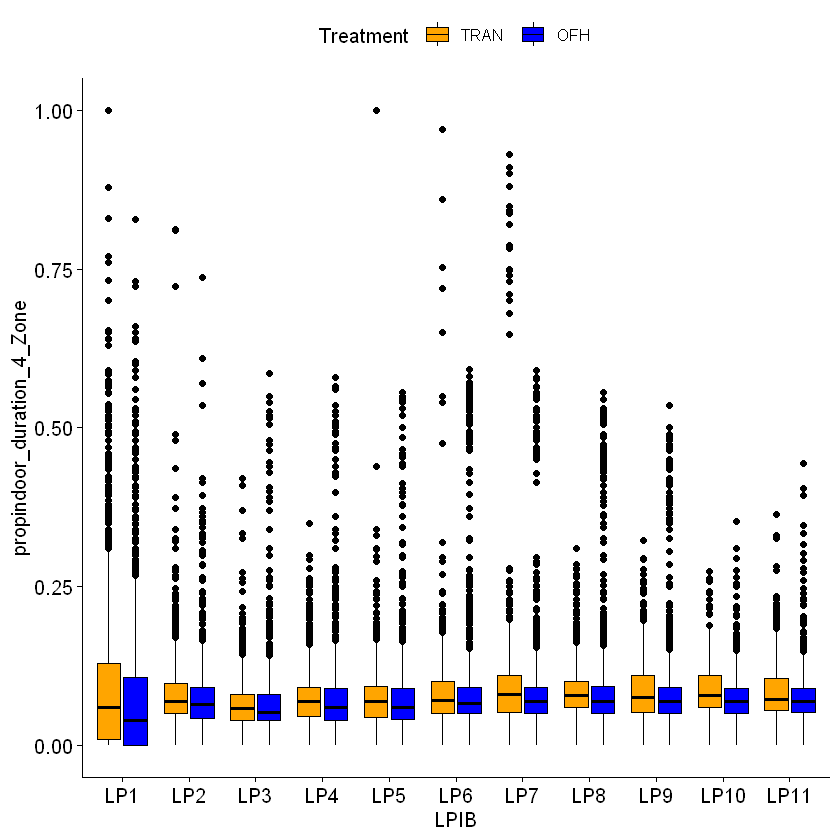

In [66]:
me = ggpredict(fit4, terms = c('time [all]','Treatment'), type = "fixed", ci.lvl = 0.95)
#TODO: add ylim!!!! plot(me$x, me$predicted, ylim=(0:1))
plot(me, color=c('orange','blue'))#, ylim=(0:1))
ggboxplot(data=df_,x='LPIB',y='propindoor_duration_4_Zone', fill='Treatment')+scale_fill_manual(values=c('orange', 'blue'))

# WG

In [129]:
set.seed(0)
dim(df)
df_ = df[, c('HenID','PenID','time','CLASS','KBF_interp','weight_interp','Treatment','time2','DIB', 'LPIB',
            'perc_1_Zone_while_WG_open')]
df_ = na.omit(df_)
dim(df_)
df_= df_ %>% group_by(DIB, Treatment) %>% slice_sample(n = ndibtreatsample)
df_$perc_1_Zone_while_WG_open = as.integer(df_$perc_1_Zone_while_WG_open)
#df_ = df_[sample(nrow(df_), 5000), ]
#remove rows from data frame with NA values in column 'b'
dim(df_)

[1] 38932    26

[1] 36472    11

[1] 36472    11

[1] 16534    26

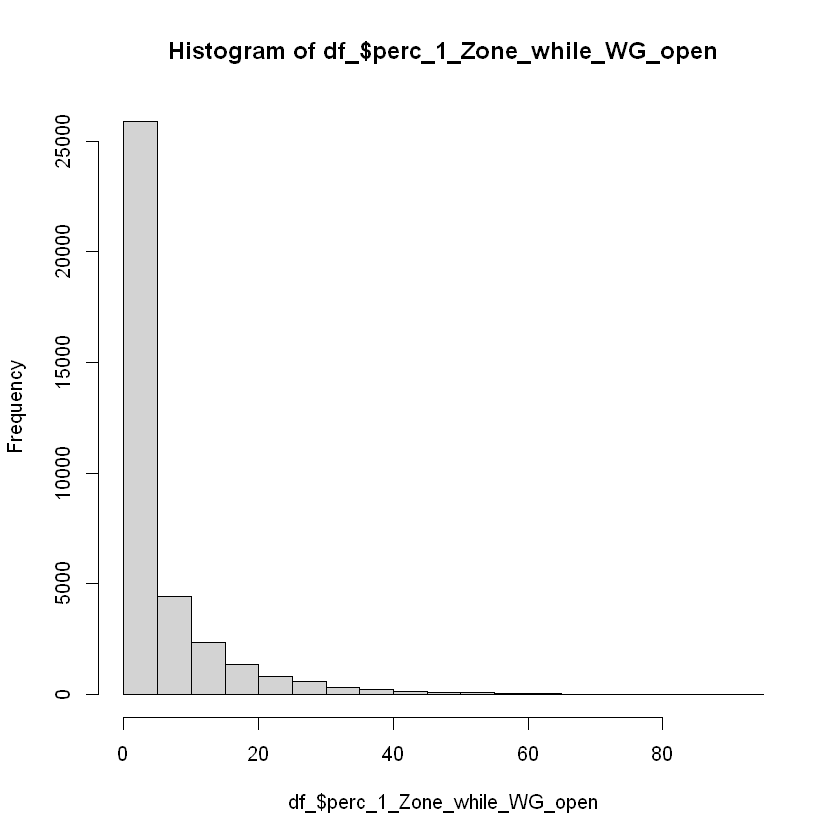

In [123]:
dim(df[df_$perc_1_Zone_while_WG_open==0,])
hist(df_$perc_1_Zone_while_WG_open)

 Family: truncated_nbinom2  ( log )
Formula:          
perc_1_Zone_while_WG_open ~ CLASS + Treatment * ns(time, 2) +  
    scale(KBF_interp) + scale(weight_interp) + (1 | PenID/HenID)
Zero inflation:                             ~Treatment
Data: df_

     AIC      BIC   logLik deviance df.resid 
171546.1 171673.6 -85758.0 171516.1    36457 

Random effects:

Conditional model:
 Groups      Name        Variance  Std.Dev. 
 HenID:PenID (Intercept) 6.801e-01 0.8246775
 PenID       (Intercept) 1.224e-07 0.0003498
Number of obs: 36472, groups:  HenID:PenID, 210; PenID, 8

Dispersion parameter for truncated_nbinom2 family (): 1.75 

Conditional model:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                1.963419   0.106015  18.520  < 2e-16 ***
CLASSLEXP                  0.102431   0.170272   0.602    0.547    
CLASSMEXP                  0.152958   0.155207   0.986    0.324    
TreatmentOFH              -0.053556   0.123986  -0.432    0.666    
ns(time

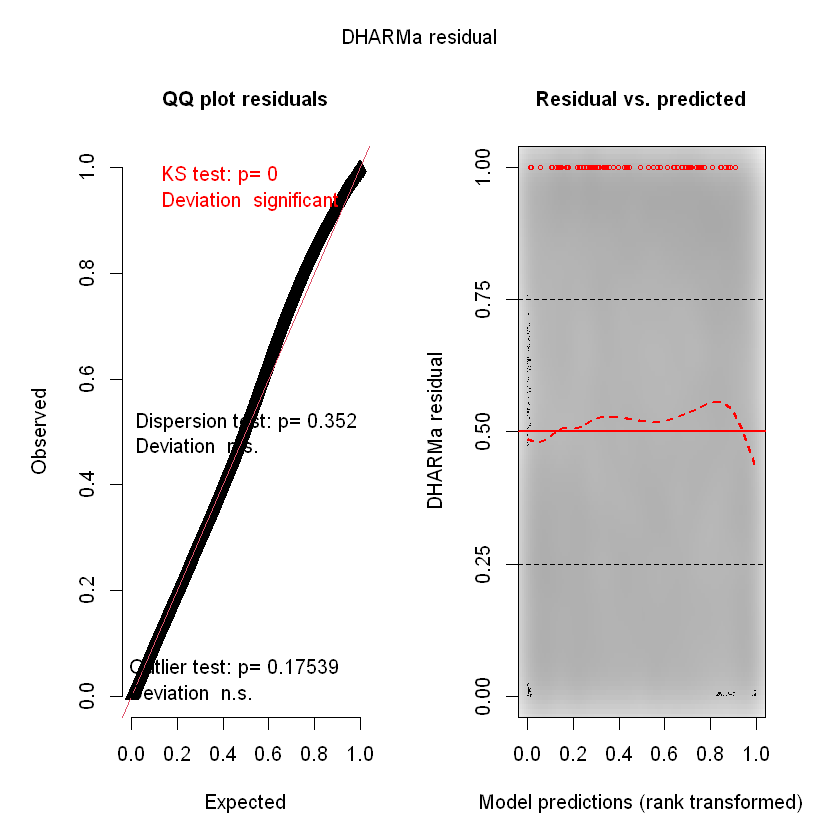

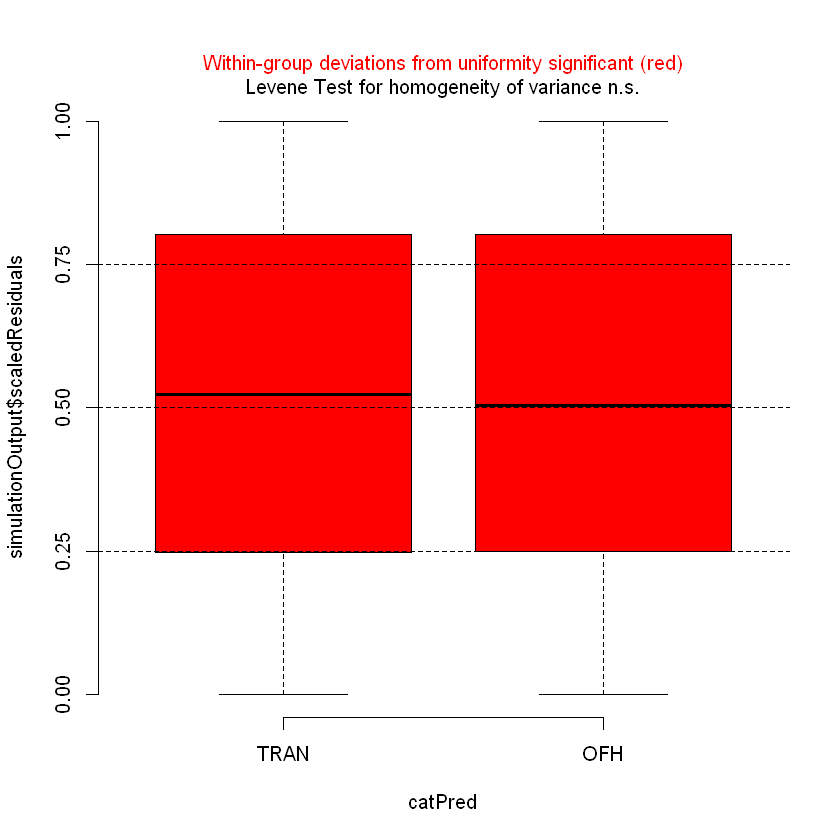

In [108]:
fitwg = glmmTMB(perc_1_Zone_while_WG_open ~ CLASS + Treatment * ns(time, 2) + scale(KBF_interp) + scale(weight_interp) + (1|PenID/HenID), 
                zi=~Treatment, df_, family=truncated_nbinom2)
summary(fitwg)
simulationOutput = simulateResiduals(fitwg)
plot(simulationOutput, quantreg = T)
plotResiduals(simulationOutput, form=df_$Treatment)

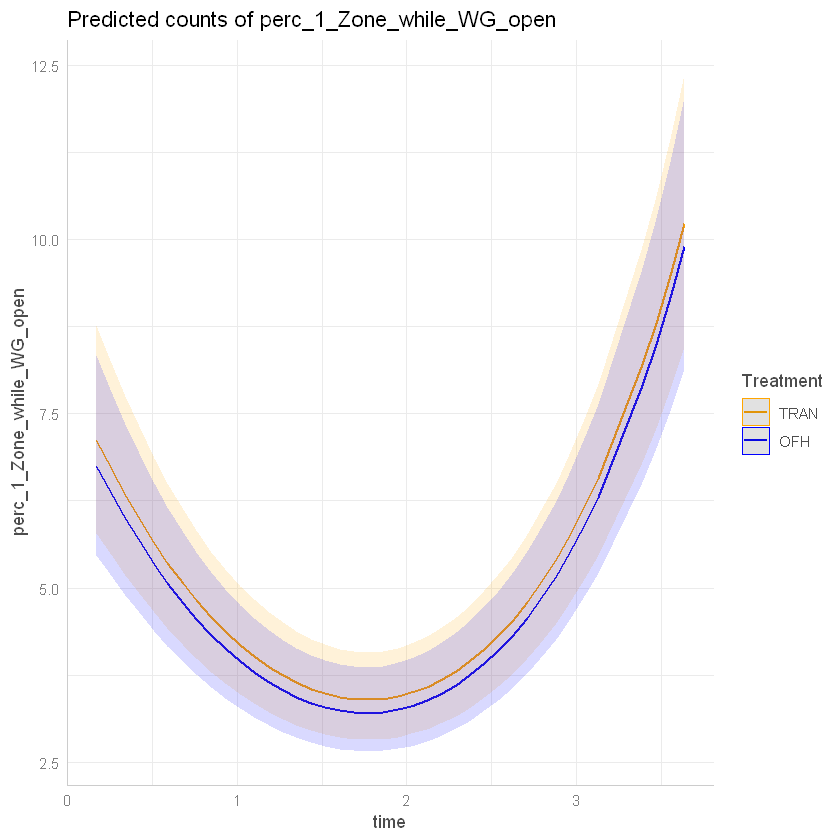

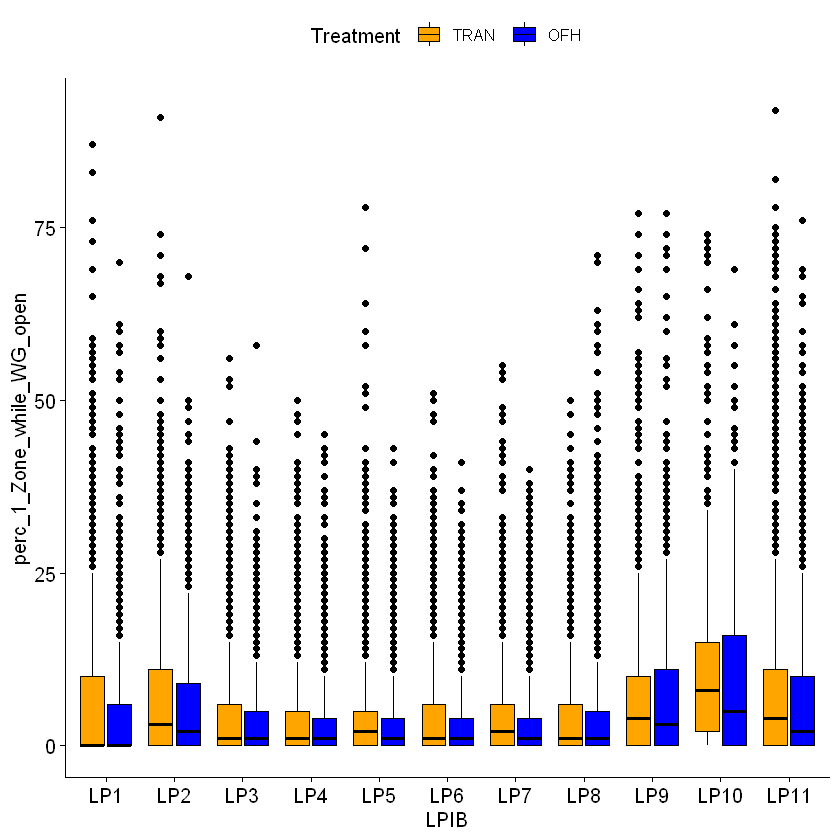

In [130]:
me = ggpredict(fitwg2, terms = c('time [all]','Treatment'), type = "fixed", ci.lvl = 0.95)
#TODO: add ylim!!!! plot(me$x, me$predicted, ylim=(0:1))
plot(me, color=c('orange','blue'))#, ylim=(0:1))
ggboxplot(data=df_,x='LPIB',y='perc_1_Zone_while_WG_open', fill='Treatment')+scale_fill_manual(values=c('orange', 'blue'))

#also kinf of worked
fitwg = glmmTMB(perc_1_Zone_while_WG_open ~  CLASS + Treatment * ns(time, 2) + scale(KBF_interp) + scale(weight_interp) + (1|PenID/HenID), 
               family = nbinom1, data=df_)
summary(fitwg)
simulationOutput = simulateResiduals(fitwg)
plot(simulationOutput, quantreg = T)
testDispersion(simulationOutput)
plotResiduals(simulationOutput, form=df_$Treatment)

#INCASE BINARY WENTINWG
df_$WentinWG = as.integer(df_$WentinWG)
fitwg0 = glmer(WentinWG ~  CLASS + Treatment * ns(time, 2) + scale(KBF_interp) + scale(weight_interp) + (1|PenID/HenID), 
               data=df_, family='binomial')
simulationOutput = simulateResiduals(fitwg0)
plot(simulationOutput, quantreg = T)
testDispersion(simulationOutput)
plotResiduals(simulationOutput, form=df_$Treatment)